In [2]:
import numpy as np
import pandas as pd
import ta
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_ta as pta

In [3]:
def get_data_from_yfinance(symbol: str, interval: str = '1h', start_date: pd.Timestamp = None, end_date: pd.Timestamp = None, invert_pair: bool = False):
    ticker_data = yf.Ticker(symbol)
    
    if start_date is None or end_date is None:
        end_date = pd.Timestamp.now()
        start_date = end_date - pd.Timedelta(days=30)  # Default to 30 days if no dates provided

    df = ticker_data.history(interval=interval, start=start_date, end=end_date)
    
    # Convert column names to lowercase
    df.columns = [col.lower() for col in df.columns]

    # Rename 'date' column to match Kraken CSV format
    df = df.reset_index().rename(columns={'index': 'date'})
    
    # Add 'trades' column with NaN values to match Kraken CSV format
    df['trades'] = np.nan

    if invert_pair:
        # Invert the price columns (Open, High, Low, Close)
        for col in ['open', 'high', 'low', 'close']:
            df[col] = 1 / df[col]
        
        # Adjust the volume
        df['volume'] = df['volume'] * df['close']
        
        # Swap High and Low
        df['high'], df['low'] = 1 / df['low'], 1 / df['high']

    return df

# Example usage:
data = get_data_from_yfinance('BTC-USD', start_date=pd.Timestamp('2024-05-11'), end_date=pd.Timestamp('2024-06-26'))
data


Datetime          open          high           low  \
0    2024-05-11 00:00:00+00:00  60791.757812  60908.621094  60656.882812   
1    2024-05-11 01:00:00+00:00  60768.191406  61057.332031  60768.191406   
2    2024-05-11 02:00:00+00:00  60879.640625  60944.312500  60759.863281   
3    2024-05-11 03:00:00+00:00  60879.781250  60883.753906  60719.632812   
4    2024-05-11 04:00:00+00:00  60728.945312  60833.984375  60714.218750   
...                        ...           ...           ...           ...   
1099 2024-06-25 19:00:00+00:00  62150.968750  62258.261719  61830.597656   
1100 2024-06-25 20:00:00+00:00  61989.871094  62062.472656  61886.519531   
1101 2024-06-25 21:00:00+00:00  61880.535156  62000.121094  61823.863281   
1102 2024-06-25 22:00:00+00:00  61930.312500  62147.949219  61872.171875   
1103 2024-06-25 23:00:00+00:00  61902.218750  61928.324219  61675.003906   

             close  volume  dividends  stock splits  trades  
0     60782.218750       0        0.0           0.0     NaN  
1     60870.664062       0        0.0           0.0     NaN  
2     60859.140625       0        0.0           0.0     NaN  
3     60719.632812       0        0.0           0.0     NaN  
4     60773.367188       0        0.0           0.0     NaN  
...            ...     ...        ...           ...     ...  
1099  62134.644531       0        0.0           0.0     NaN  
1100  61890.632812       0        0.0           0.0     NaN  
1101  61888.550781       0        0.0           0.0     NaN  
1102  61901.339844       0        0.0           0.0     NaN  
1103  61808.593750       0        0.0           0.0     NaN  

[1104 rows x 9 columns]

In [4]:
base_kraken_path = '../data/kraken'

def get_data_from_kraken_csv(symbol: str, interval: str, window: int = None, skip: int = None, buffer: int = None, start_date: pd.Timestamp = None, end_date: pd.Timestamp = None):
    column_names = ['date_unix', 'open', 'high', 'low', 'close', 'volume', 'trades']
    df = pd.read_csv(f'{base_kraken_path}/{symbol}_{interval}.csv', names=column_names)
    
    df['date'] = pd.to_datetime(df['date_unix'], unit='s')
    del df['date_unix']
    df = df.set_index('date')

    if start_date is not None and end_date is not None:
        df = df[start_date:end_date]
    else:
        start_index = max(len(df) - window - buffer - window * skip, 0)
        end_index = max(len(df) - window * skip, 0)
        df = df.iloc[start_index:end_index]
    return df

#data = get_data_from_kraken_csv('XBTUSDT', '60', 720, 4, 168)
data = get_data_from_kraken_csv('XBTUSDT', '60', start_date=pd.Timestamp('2021-09-01'), end_date=pd.Timestamp('2021-10-01'))
data

open     high      low    close    volume  trades
date                                                                     
2021-09-01 00:00:00  47103.8  47289.0  46748.9  46763.4  6.454117     136
2021-09-01 01:00:00  46734.3  46861.4  46560.6  46861.4  7.247905     145
2021-09-01 02:00:00  46820.3  47084.7  46761.6  46874.0  0.933202      67
2021-09-01 03:00:00  46868.9  47005.4  46740.3  47005.4  1.168069      91
2021-09-01 04:00:00  47022.6  47240.2  46981.9  47129.4  4.546941     119
...                      ...      ...      ...      ...       ...     ...
2021-09-30 20:00:00  43558.6  43735.6  43156.3  43431.8  7.368952     168
2021-09-30 21:00:00  43408.6  43787.5  43390.9  43787.5  3.137095     163
2021-09-30 22:00:00  43785.4  43898.4  43652.8  43742.9  4.778271     103
2021-09-30 23:00:00  43753.7  43890.0  43637.9  43824.0  2.340164      45
2021-10-01 00:00:00  43804.5  44049.6  43696.6  43746.7  4.633744     108

[721 rows x 6 columns]

# Simple indicators

In [633]:
data = get_data_from_yfinance('SOL-BTC', start_date=pd.Timestamp('2022-12-01'), end_date=pd.Timestamp('2023-01-01'), invert_pair=False)

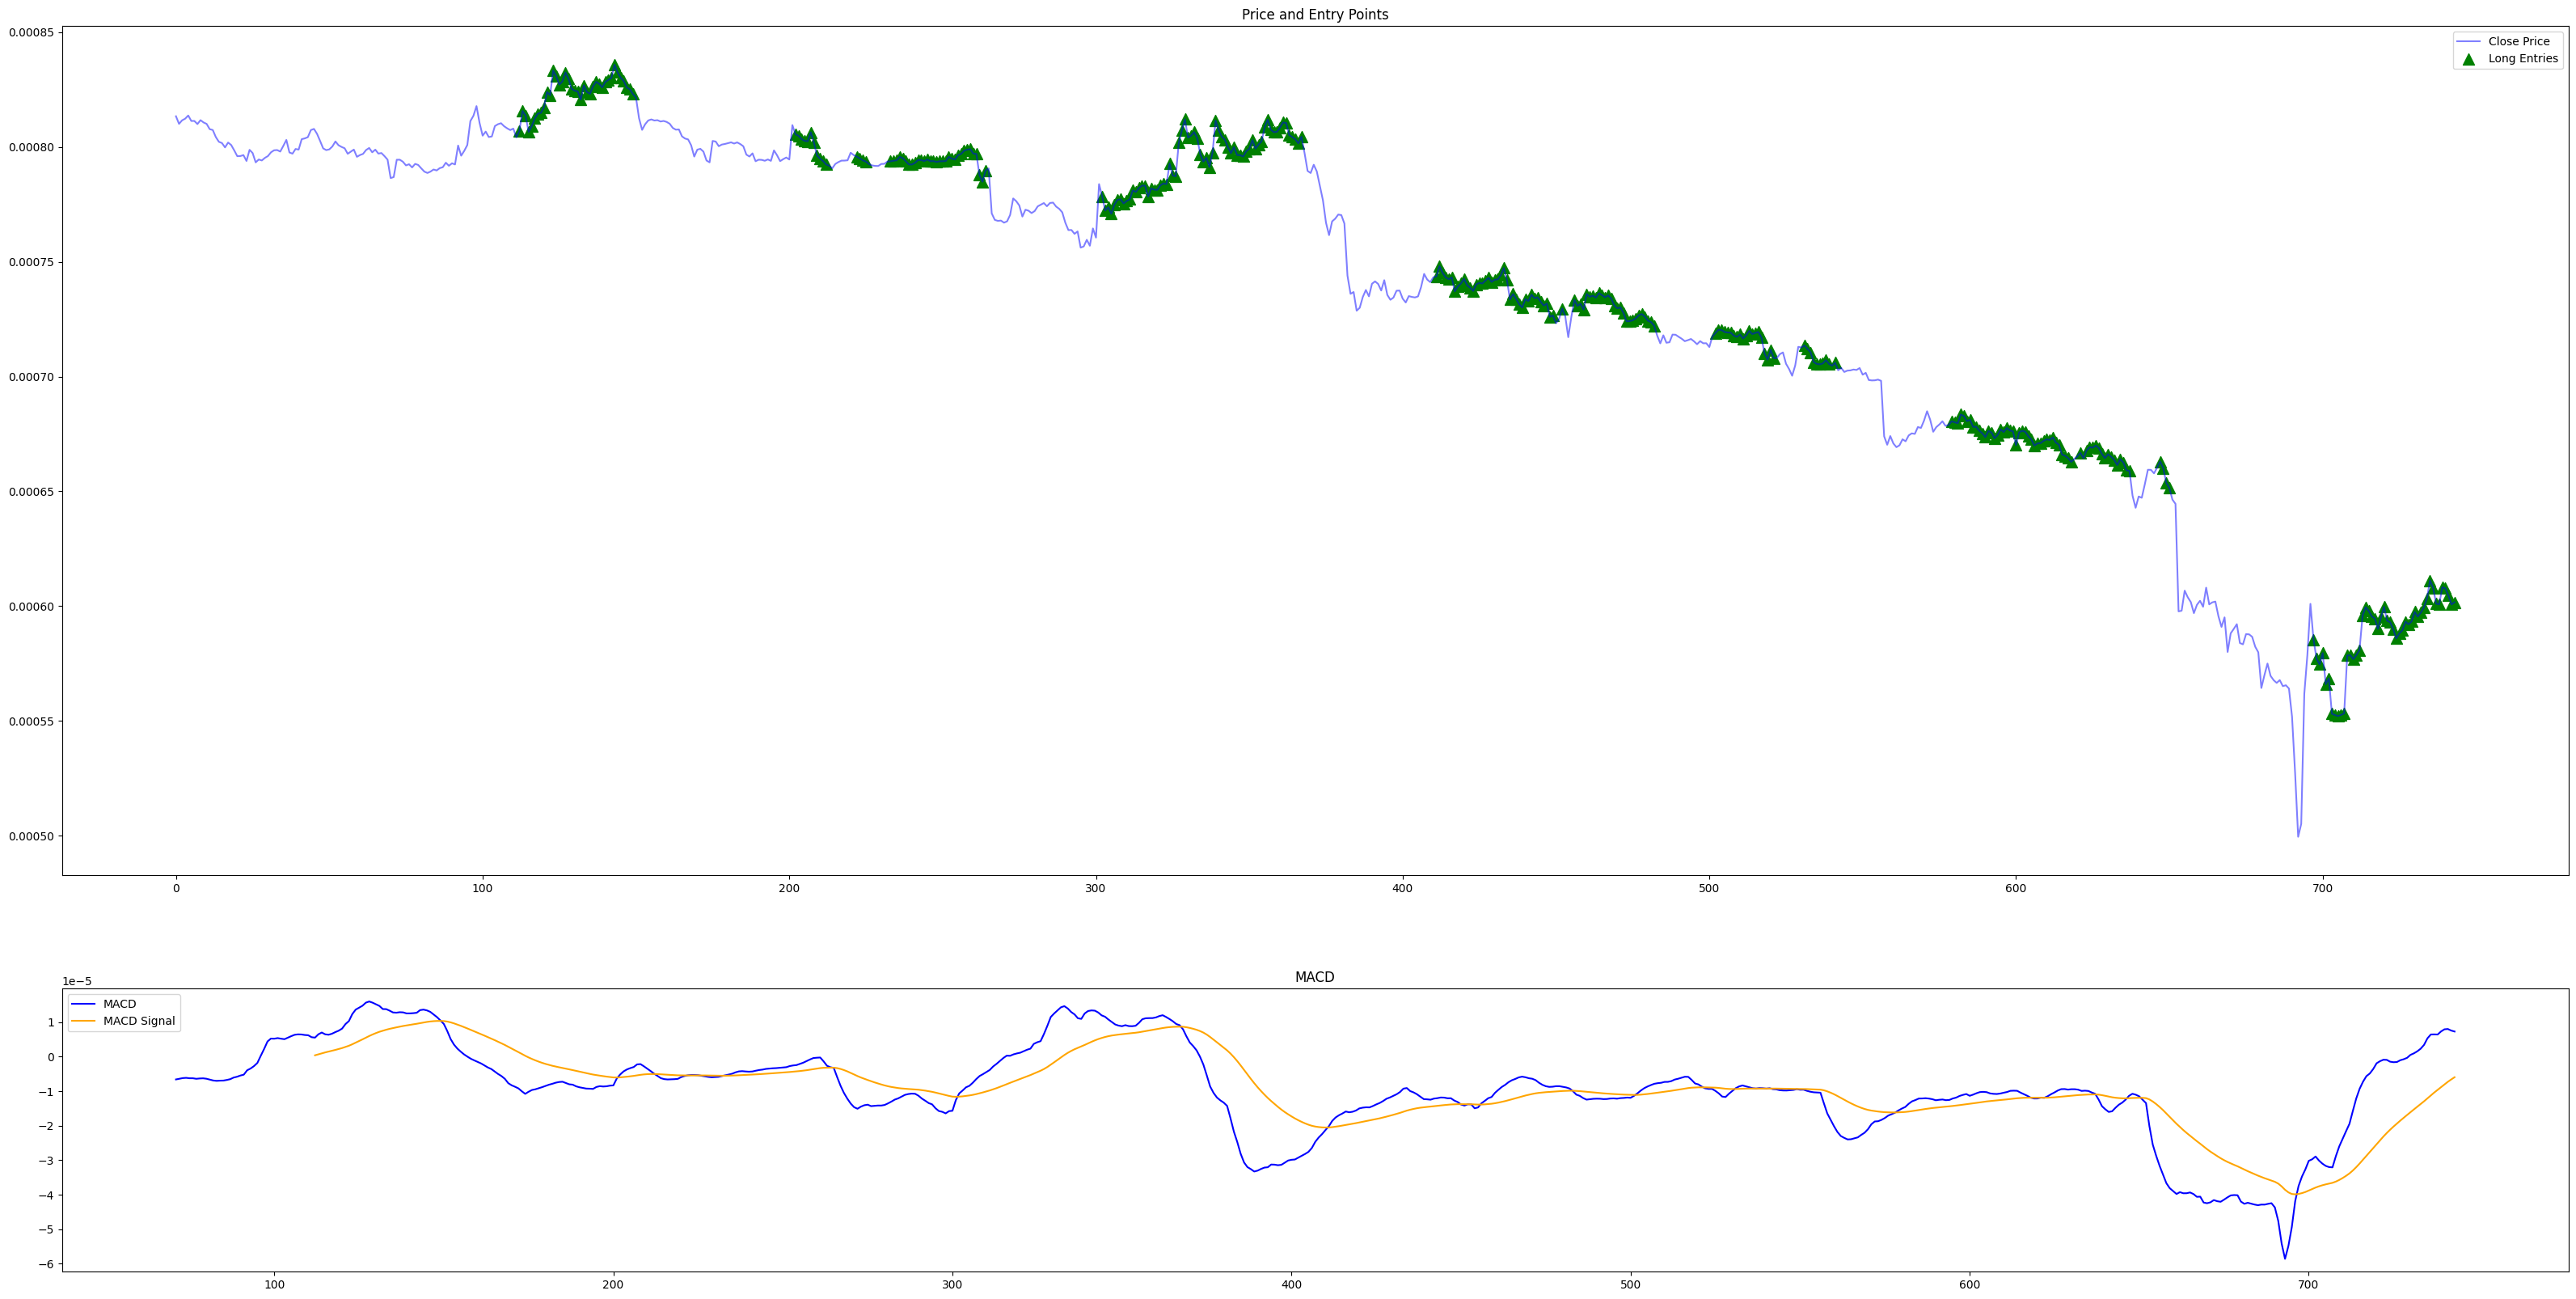

In [634]:
# Calculate MACD and its signal line
data['macd'] = ta.trend.macd(data['close'], window_slow=72, window_fast=12)
data['macd_signal'] = ta.trend.macd_signal(data['close'], window_slow=72, window_fast=12, window_sign=42)

data['macd_last'] = data['macd'].shift(1)
data['macd_signal_last'] = data['macd_signal'].shift(1)

data['long_entry'] = (data['macd'] > data['macd_signal'])
data['short_entry'] = (data['macd_signal'] < data['macd'])

# Plotting the price, MACD, RSI, and CCI for visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), gridspec_kw={'height_ratios': [3, 1]})

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
#ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.set_title('Price and Entry Points')
ax1.legend()

# Plot MACD
ax2.plot(data['macd'], label='MACD', color='blue')
ax2.plot(data['macd_signal'], label='MACD Signal', color='orange')
ax2.set_title('MACD')
ax2.legend()

plt.show()


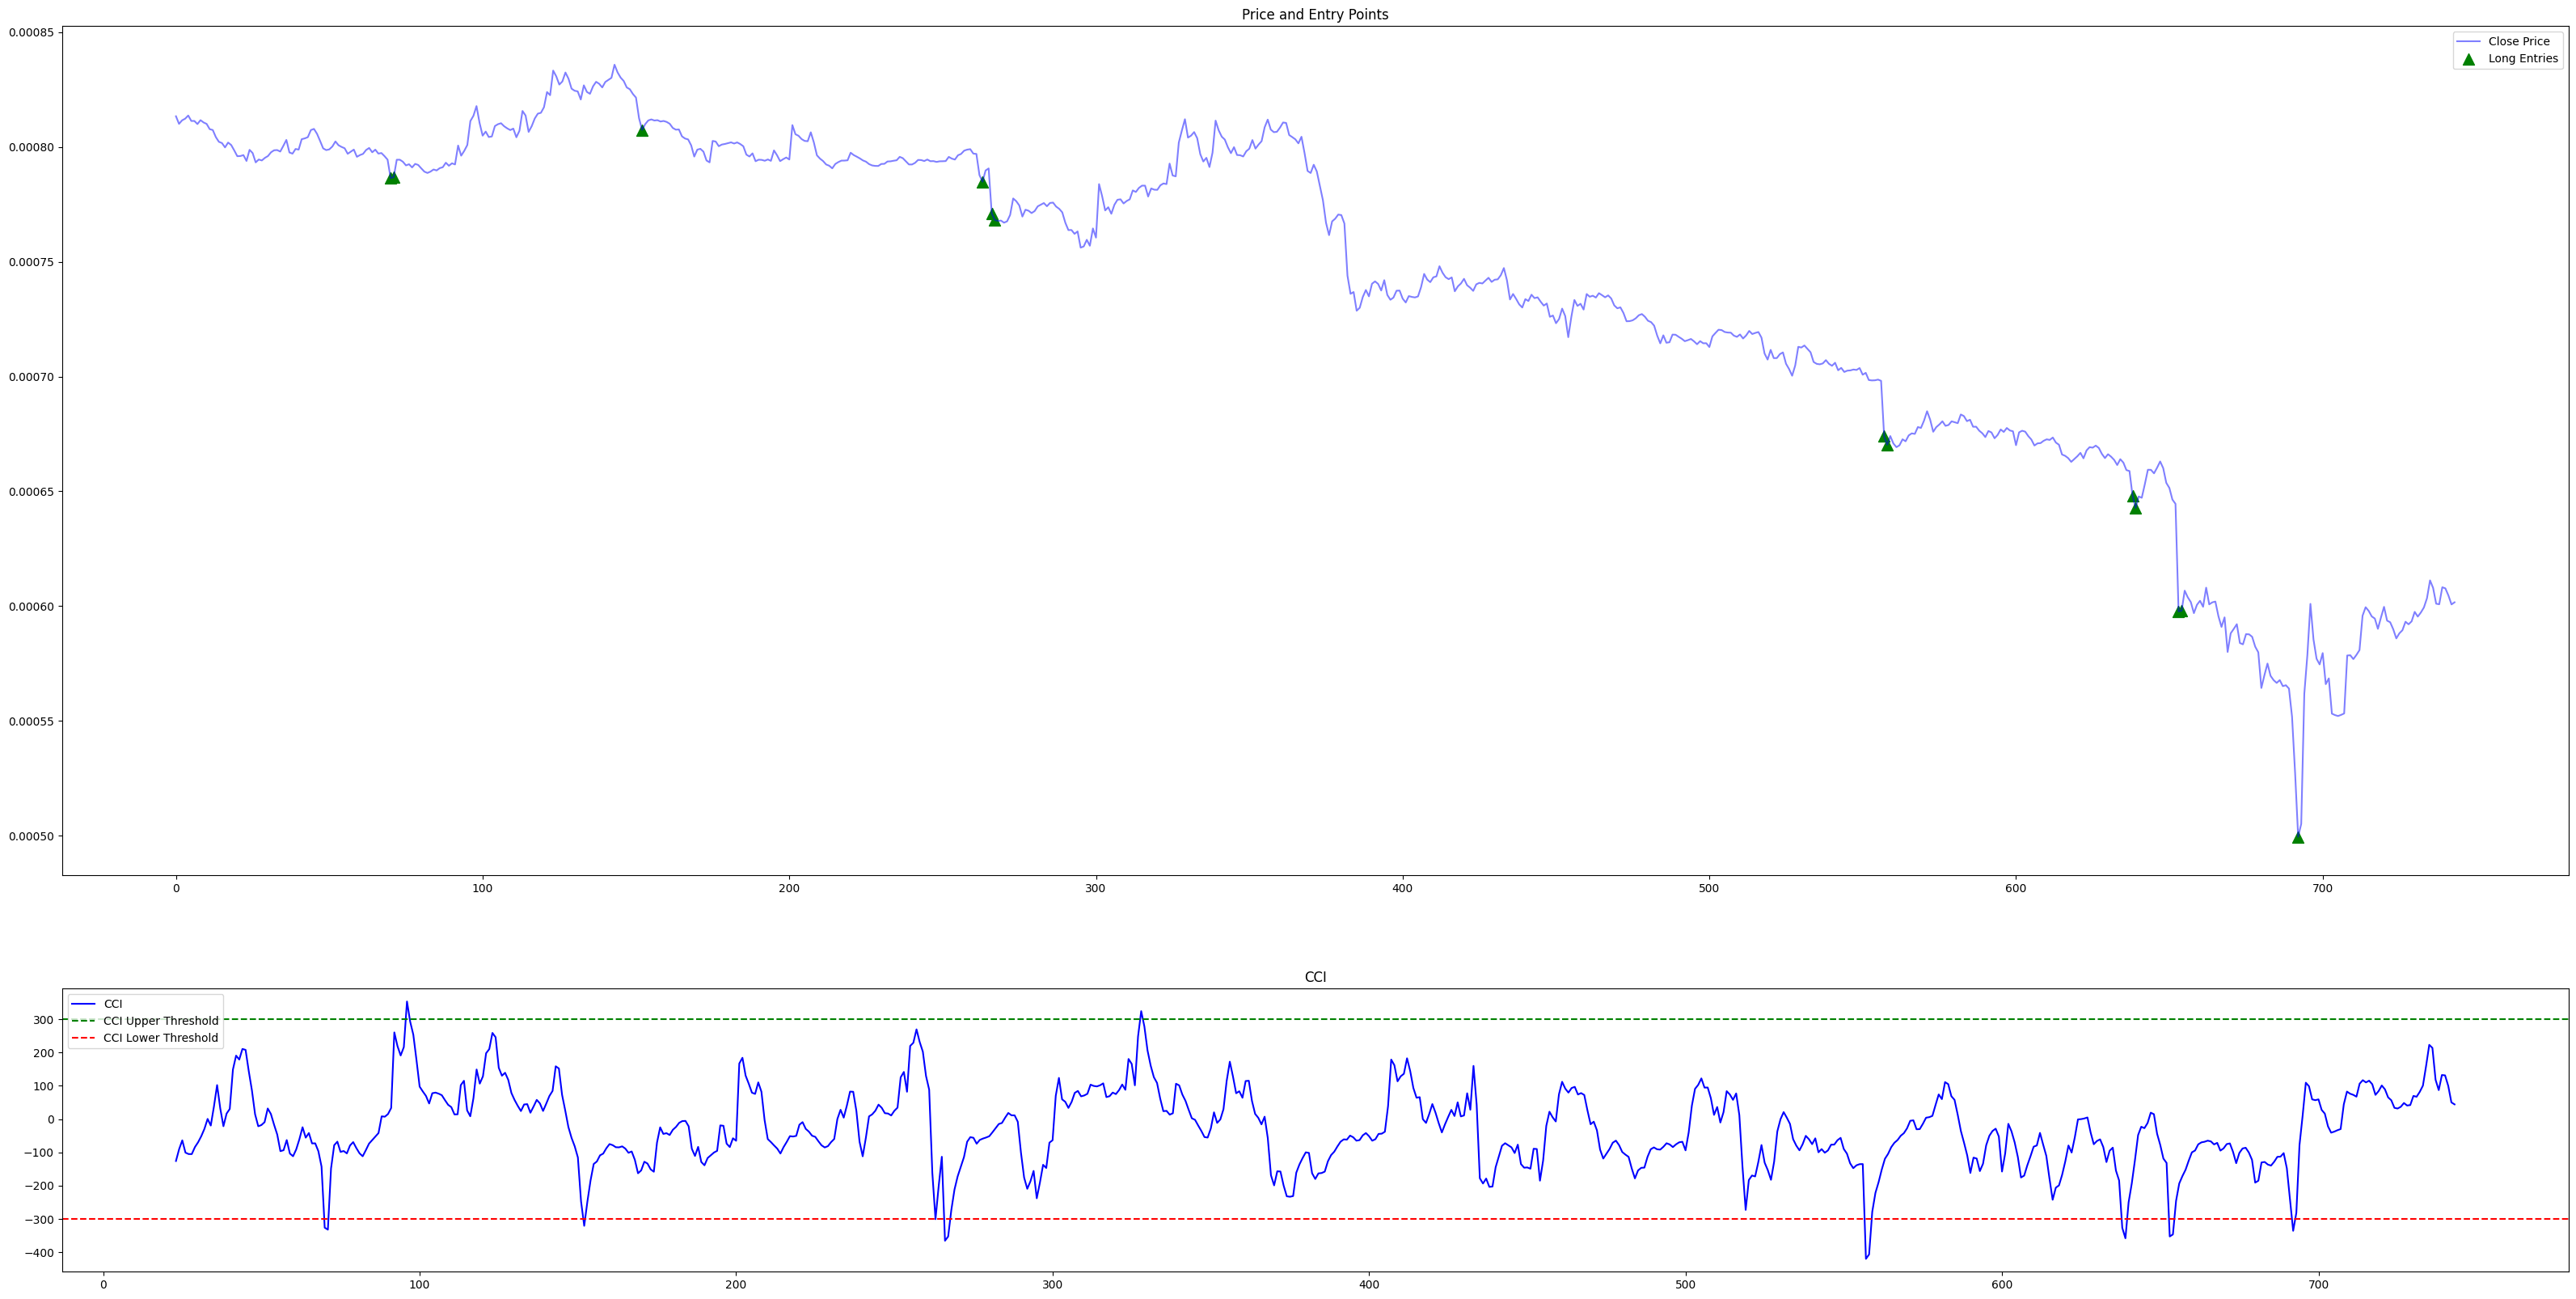

In [635]:
# Calculate CCI
data['cci'] = ta.trend.cci(data['high'], data['low'], data['close'], window=24)

# Define CCI trend direction with a reasonable margin
cci_upper_threshold = 300
cci_lower_threshold = -300
data['cci_oversold'] = data['cci'] < cci_lower_threshold
data['cci_overbought'] = data['cci'] > cci_upper_threshold

data['long_entry'] = data['cci_oversold']
data['short_entry'] = data['cci_overbought']

# Plotting the price, CCI, RSI, and CCI for visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), gridspec_kw={'height_ratios': [3, 1]})

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
#ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.set_title('Price and Entry Points')
ax1.legend()

# Plot CCI
ax2.plot(data['cci'], label='CCI', color='blue')
ax2.axhline(y=cci_upper_threshold, color='green', linestyle='--', label='CCI Upper Threshold')
ax2.axhline(y=cci_lower_threshold, color='red', linestyle='--', label='CCI Lower Threshold')
ax2.set_title('CCI')
ax2.legend()

plt.show()

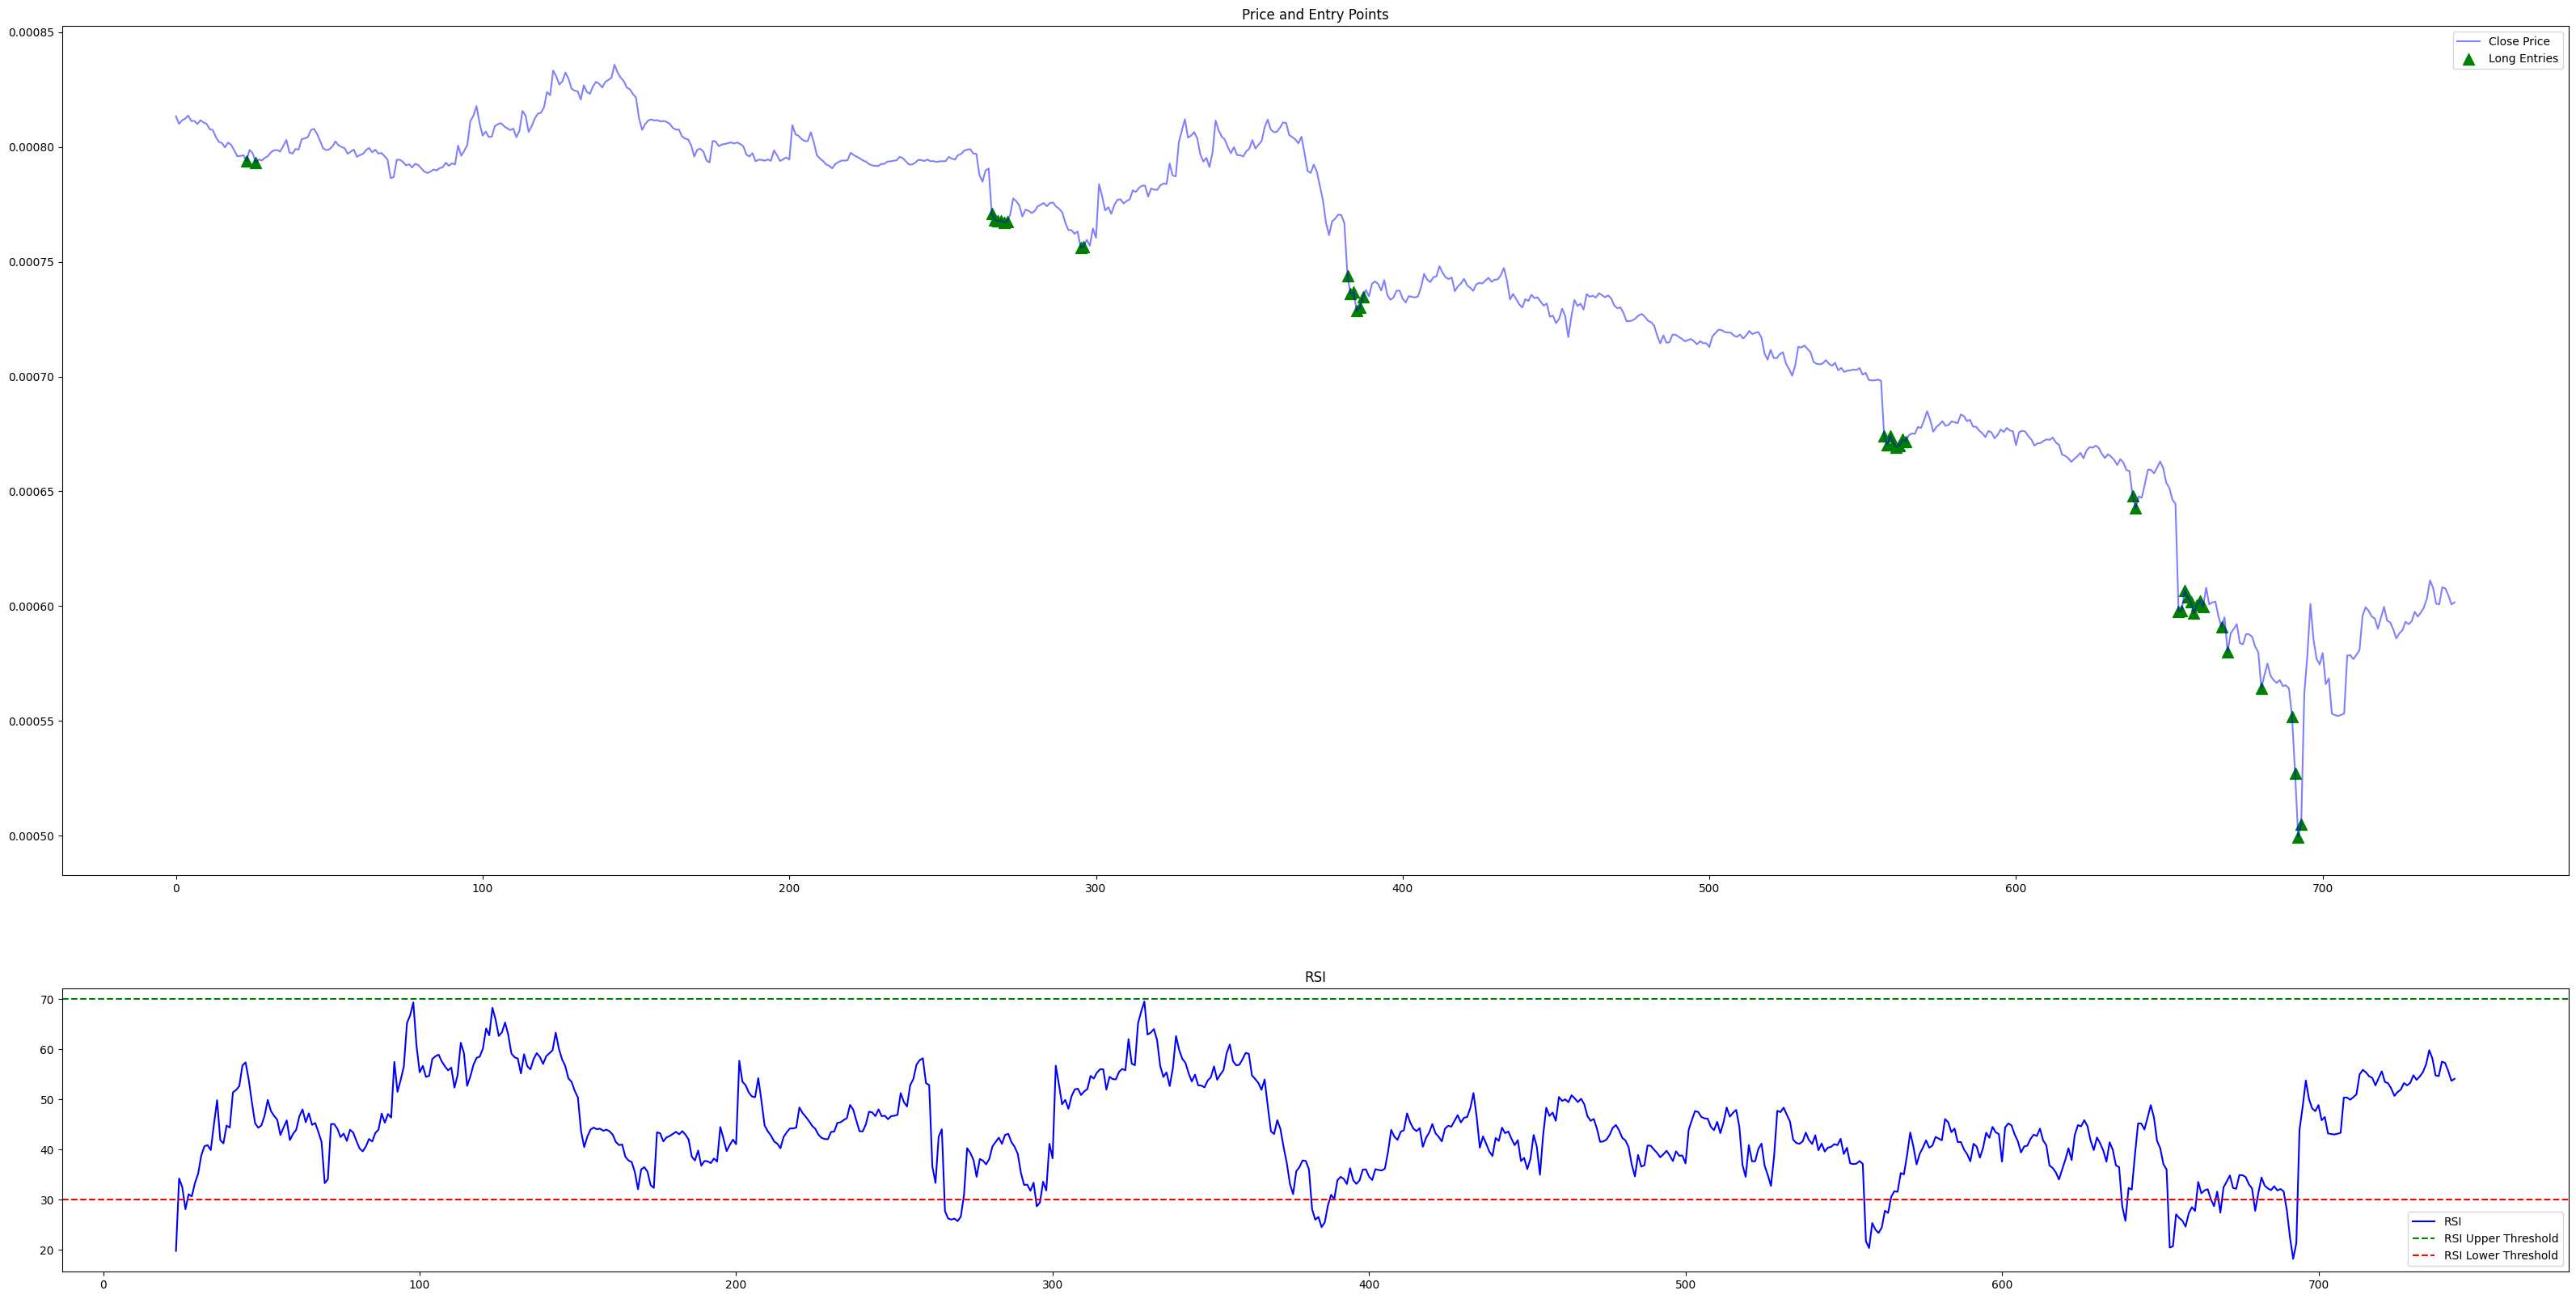

In [636]:
# Calculate RSI
data['rsi'] = ta.momentum.rsi(data['close'], window=24)

# Define RSI trend direction with a reasonable margin
rsi_upper_threshold = 70
rsi_lower_threshold = 30
data['rsi_oversold'] = data['rsi'] < rsi_lower_threshold
data['rsi_overbought'] = data['rsi'] > rsi_upper_threshold

data['long_entry'] = data['rsi_oversold']
data['short_entry'] = data['rsi_overbought']

# Plotting the price and RSI for visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), gridspec_kw={'height_ratios': [3, 1]})

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
#ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.set_title('Price and Entry Points')
ax1.legend()

# Plot RSI
ax2.plot(data['rsi'], label='RSI', color='blue')
ax2.axhline(y=rsi_upper_threshold, color='green', linestyle='--', label='RSI Upper Threshold')
ax2.axhline(y=rsi_lower_threshold, color='red', linestyle='--', label='RSI Lower Threshold')
ax2.set_title('RSI')
ax2.legend()

plt.show()

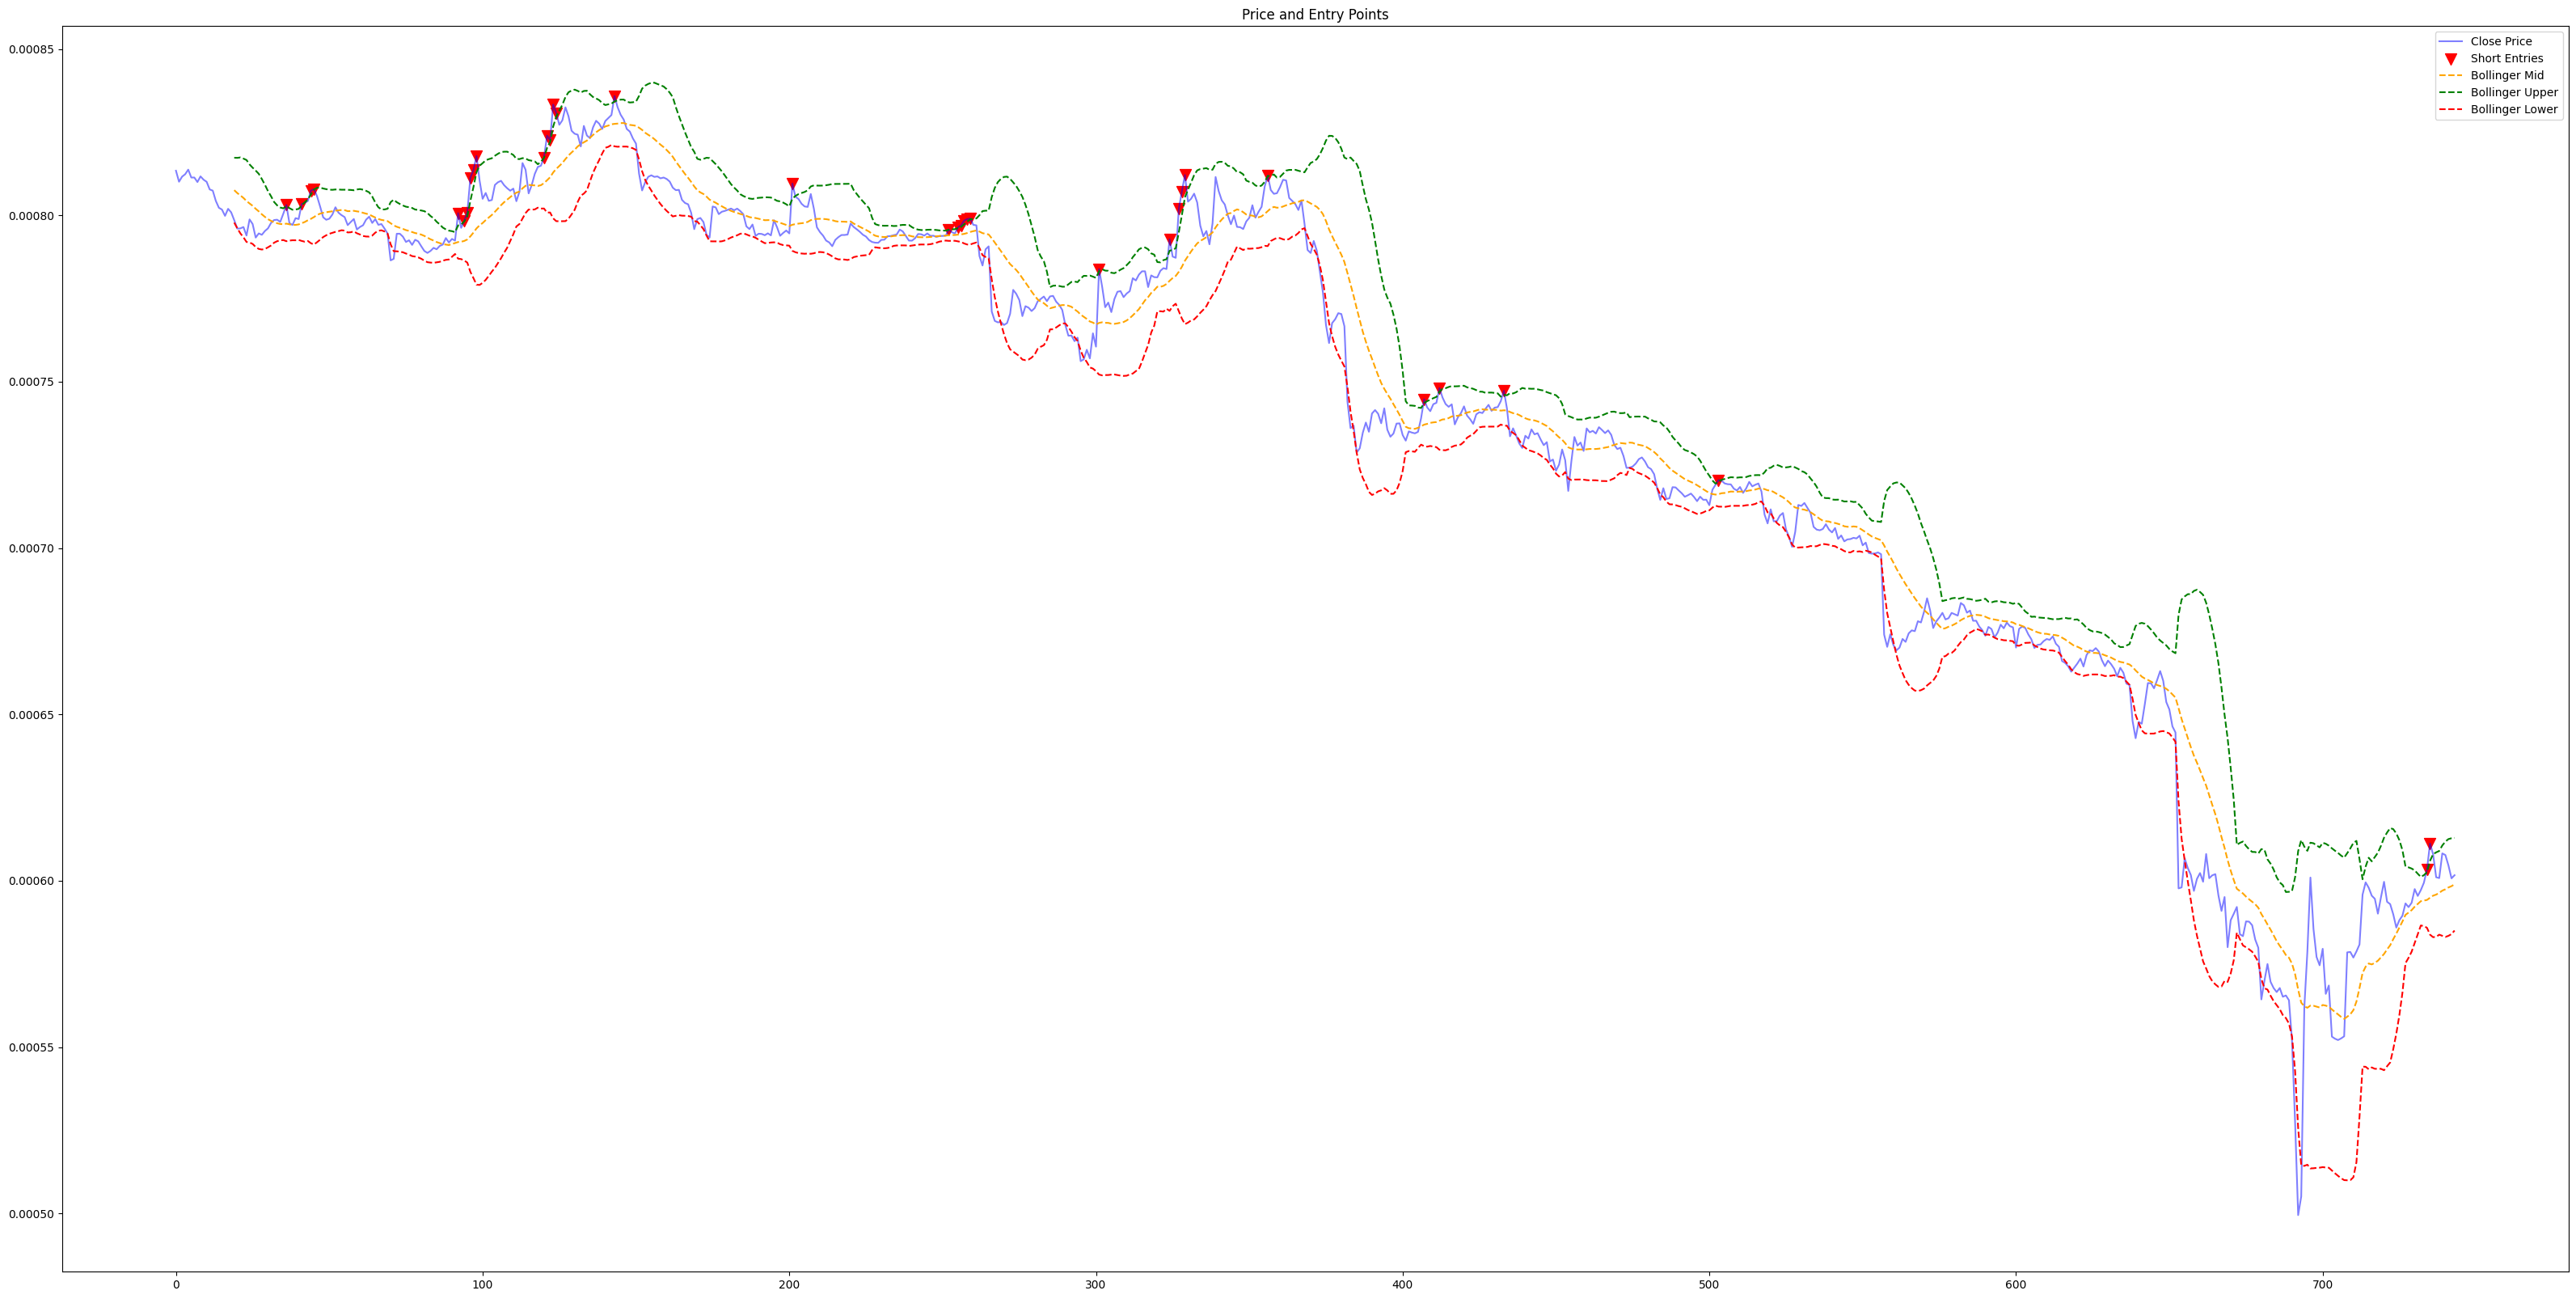

In [625]:
# Calculate Bollinger Bands
data['bollinger_mid'] = ta.volatility.bollinger_mavg(data['close'])
data['bollinger_upper'] = ta.volatility.bollinger_hband(data['close'])
data['bollinger_lower'] = ta.volatility.bollinger_lband(data['close'])

# Define Bollinger Bands trend direction with a minimum margin for the cross-over
data['long_entry'] = data['close'] < data['bollinger_lower']
data['short_entry'] = data['close'] > data['bollinger_upper']

# Plotting the price and Bollinger Bands for visualization
fig, (ax1) = plt.subplots(1, 1, figsize=(40, 20))

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
#ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)
ax1.scatter(data.index[data['short_entry']], data['close'][data['short_entry']], label='Short Entries', color='red', marker='v', s=100)
ax1.plot(data['bollinger_mid'], label='Bollinger Mid', color='orange', linestyle='--')
ax1.plot(data['bollinger_upper'], label='Bollinger Upper', color='green', linestyle='--')
ax1.plot(data['bollinger_lower'], label='Bollinger Lower', color='red', linestyle='--')
ax1.set_title('Price and Entry Points')
ax1.legend()

plt.show()

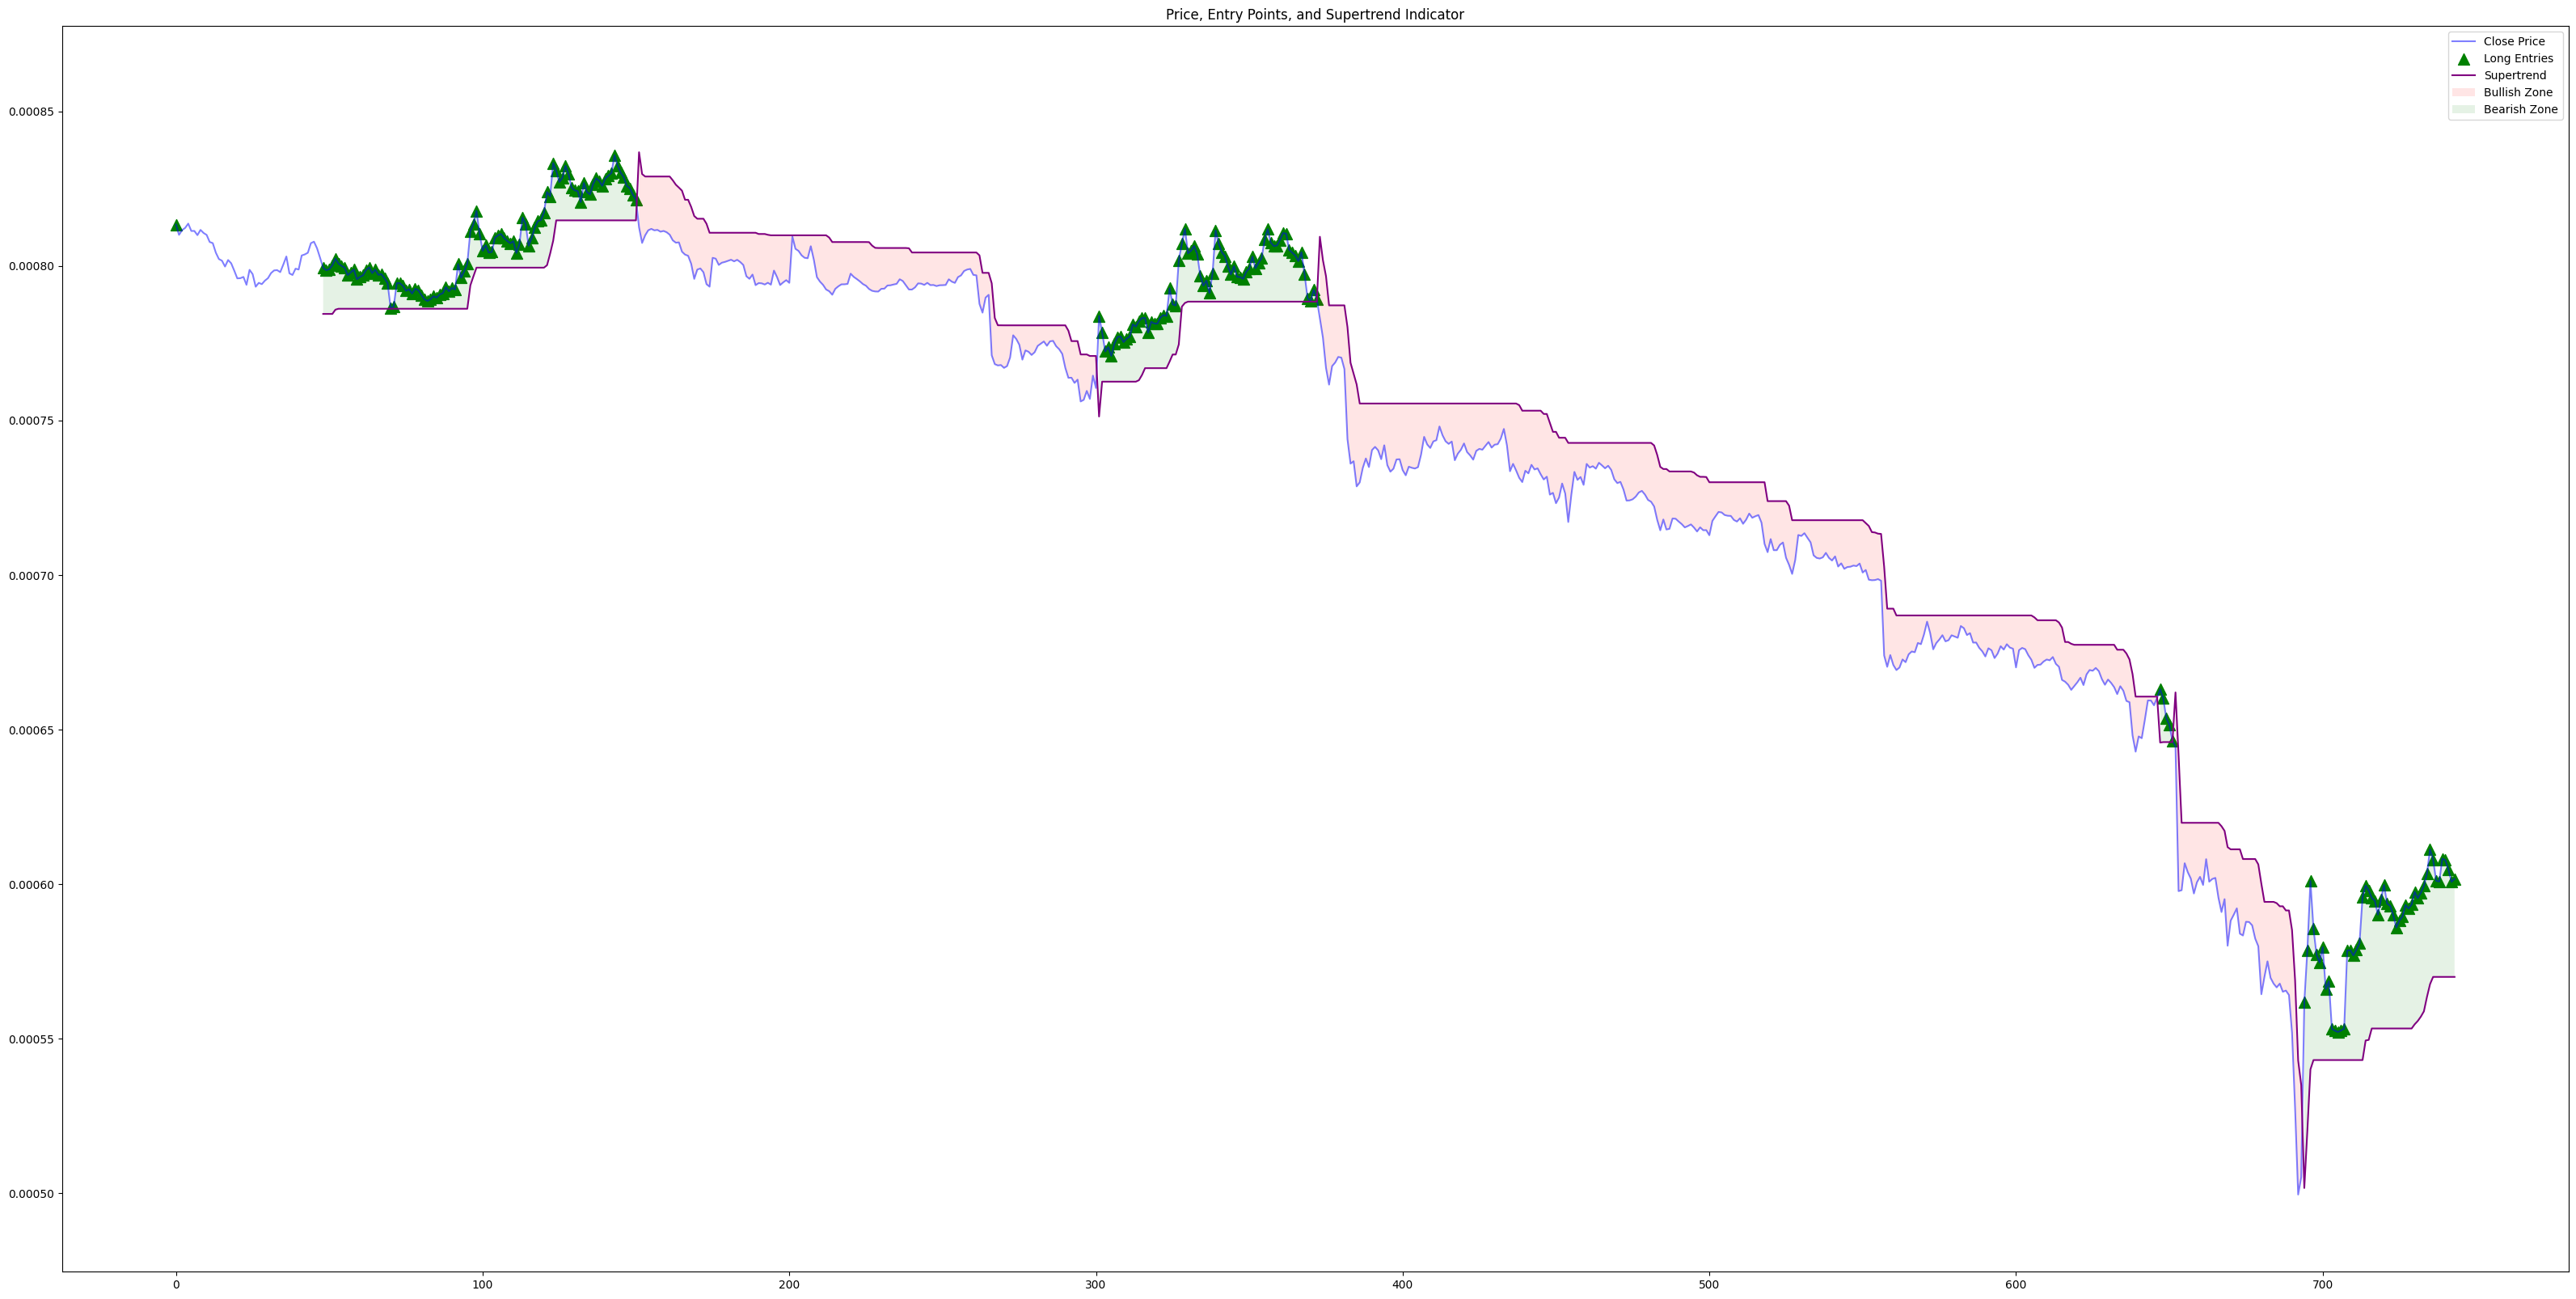

In [626]:
# Calculate Supertrend using pandas_ta
import pandas_ta as pta

supertrend_data = pta.supertrend(data['high'], data['low'], data['close'], length=48, multiplier=5)
data['supertrend'] = supertrend_data['SUPERT_48_5.0']

# Define Supertrend trend direction for entry and exit
data['long_entry'] = (data['supertrend'] <= data['close'])

# Plotting the price and Supertrend for visualization
fig, ax1 = plt.subplots(1, 1, figsize=(40, 20))

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=100)

# Overlay Supertrend on the same axis as price
ax1.plot(data['supertrend'], label='Supertrend', color='purple')
ax1.fill_between(data.index, data['supertrend'], data['close'], where=data['supertrend'] > data['close'], facecolor='red', alpha=0.1, label='Bullish Zone')
ax1.fill_between(data.index, data['supertrend'], data['close'], where=data['supertrend'] < data['close'], facecolor='green', alpha=0.1, label='Bearish Zone')

ax1.set_title('Price, Entry Points, and Supertrend Indicator')
ax1.legend()

ax1.set_ylim(data['close'].min() * .95, data['close'].max() * 1.05)  # Set y-axis scale from 35000 to 50000

plt.show()



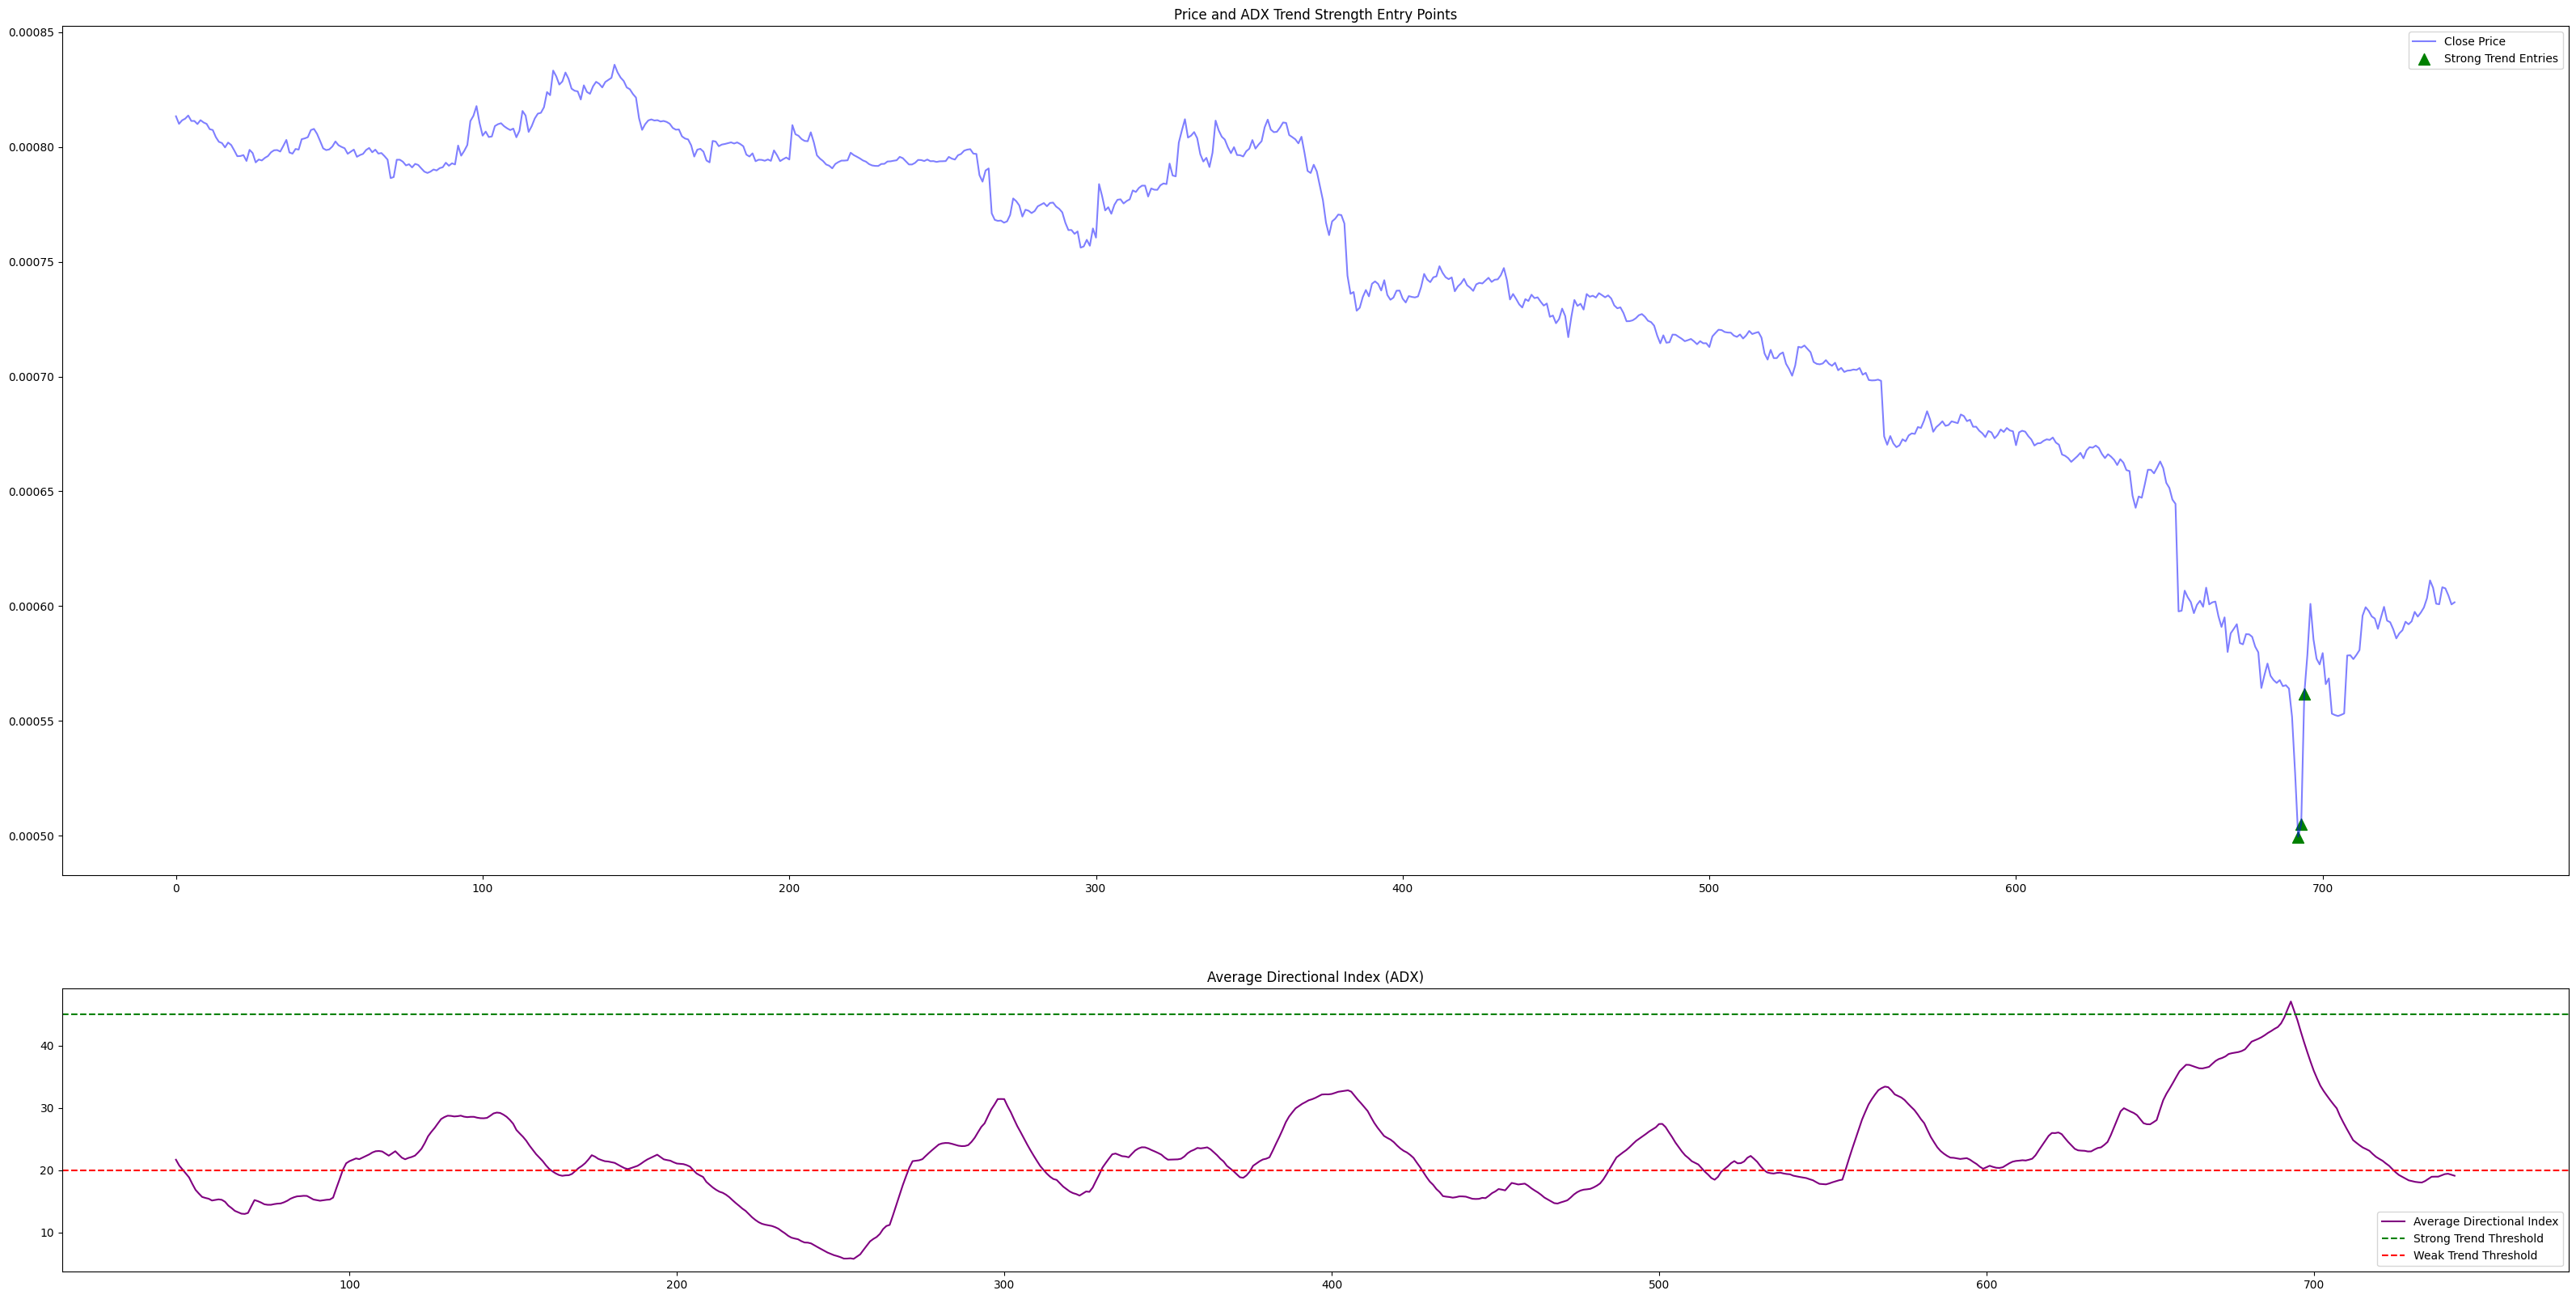

In [627]:
# Calculate ADX using pandas_ta
data['adx'] = pta.adx(data['high'], data['low'], data['close'], length=24)['ADX_24']

# Define ADX trend strength thresholds
adx_strong = 45
adx_weak = 20

# Define entry points based on ADX strength
data['strong_trend_entry'] = data['adx'] > adx_strong
data['weak_trend_entry'] = data['adx'] < adx_weak

# Plotting the price and ADX for visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 20), gridspec_kw={'height_ratios': [3, 1]})

# Plot price and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.scatter(data.index[data['strong_trend_entry']], data['close'][data['strong_trend_entry']], label='Strong Trend Entries', color='green', marker='^', s=100)
#ax1.scatter(data.index[data['weak_trend_entry']], data['close'][data['weak_trend_entry']], label='Weak Trend Entries', color='red', marker='v', s=100)
ax1.set_title('Price and ADX Trend Strength Entry Points')
ax1.legend()

# Plot ADX
ax2.plot(data['adx'], label='Average Directional Index', color='purple')
ax2.axhline(adx_strong, color='green', linestyle='--', label='Strong Trend Threshold')
ax2.axhline(adx_weak, color='red', linestyle='--', label='Weak Trend Threshold')
ax2.set_title('Average Directional Index (ADX)')
ax2.legend()

plt.show()


# Strategies

In [1523]:
data = get_data_from_yfinance('BTC-GBP', start_date=pd.Timestamp('2022-12-01'), end_date=pd.Timestamp('2024-08-01'), invert_pair=True)

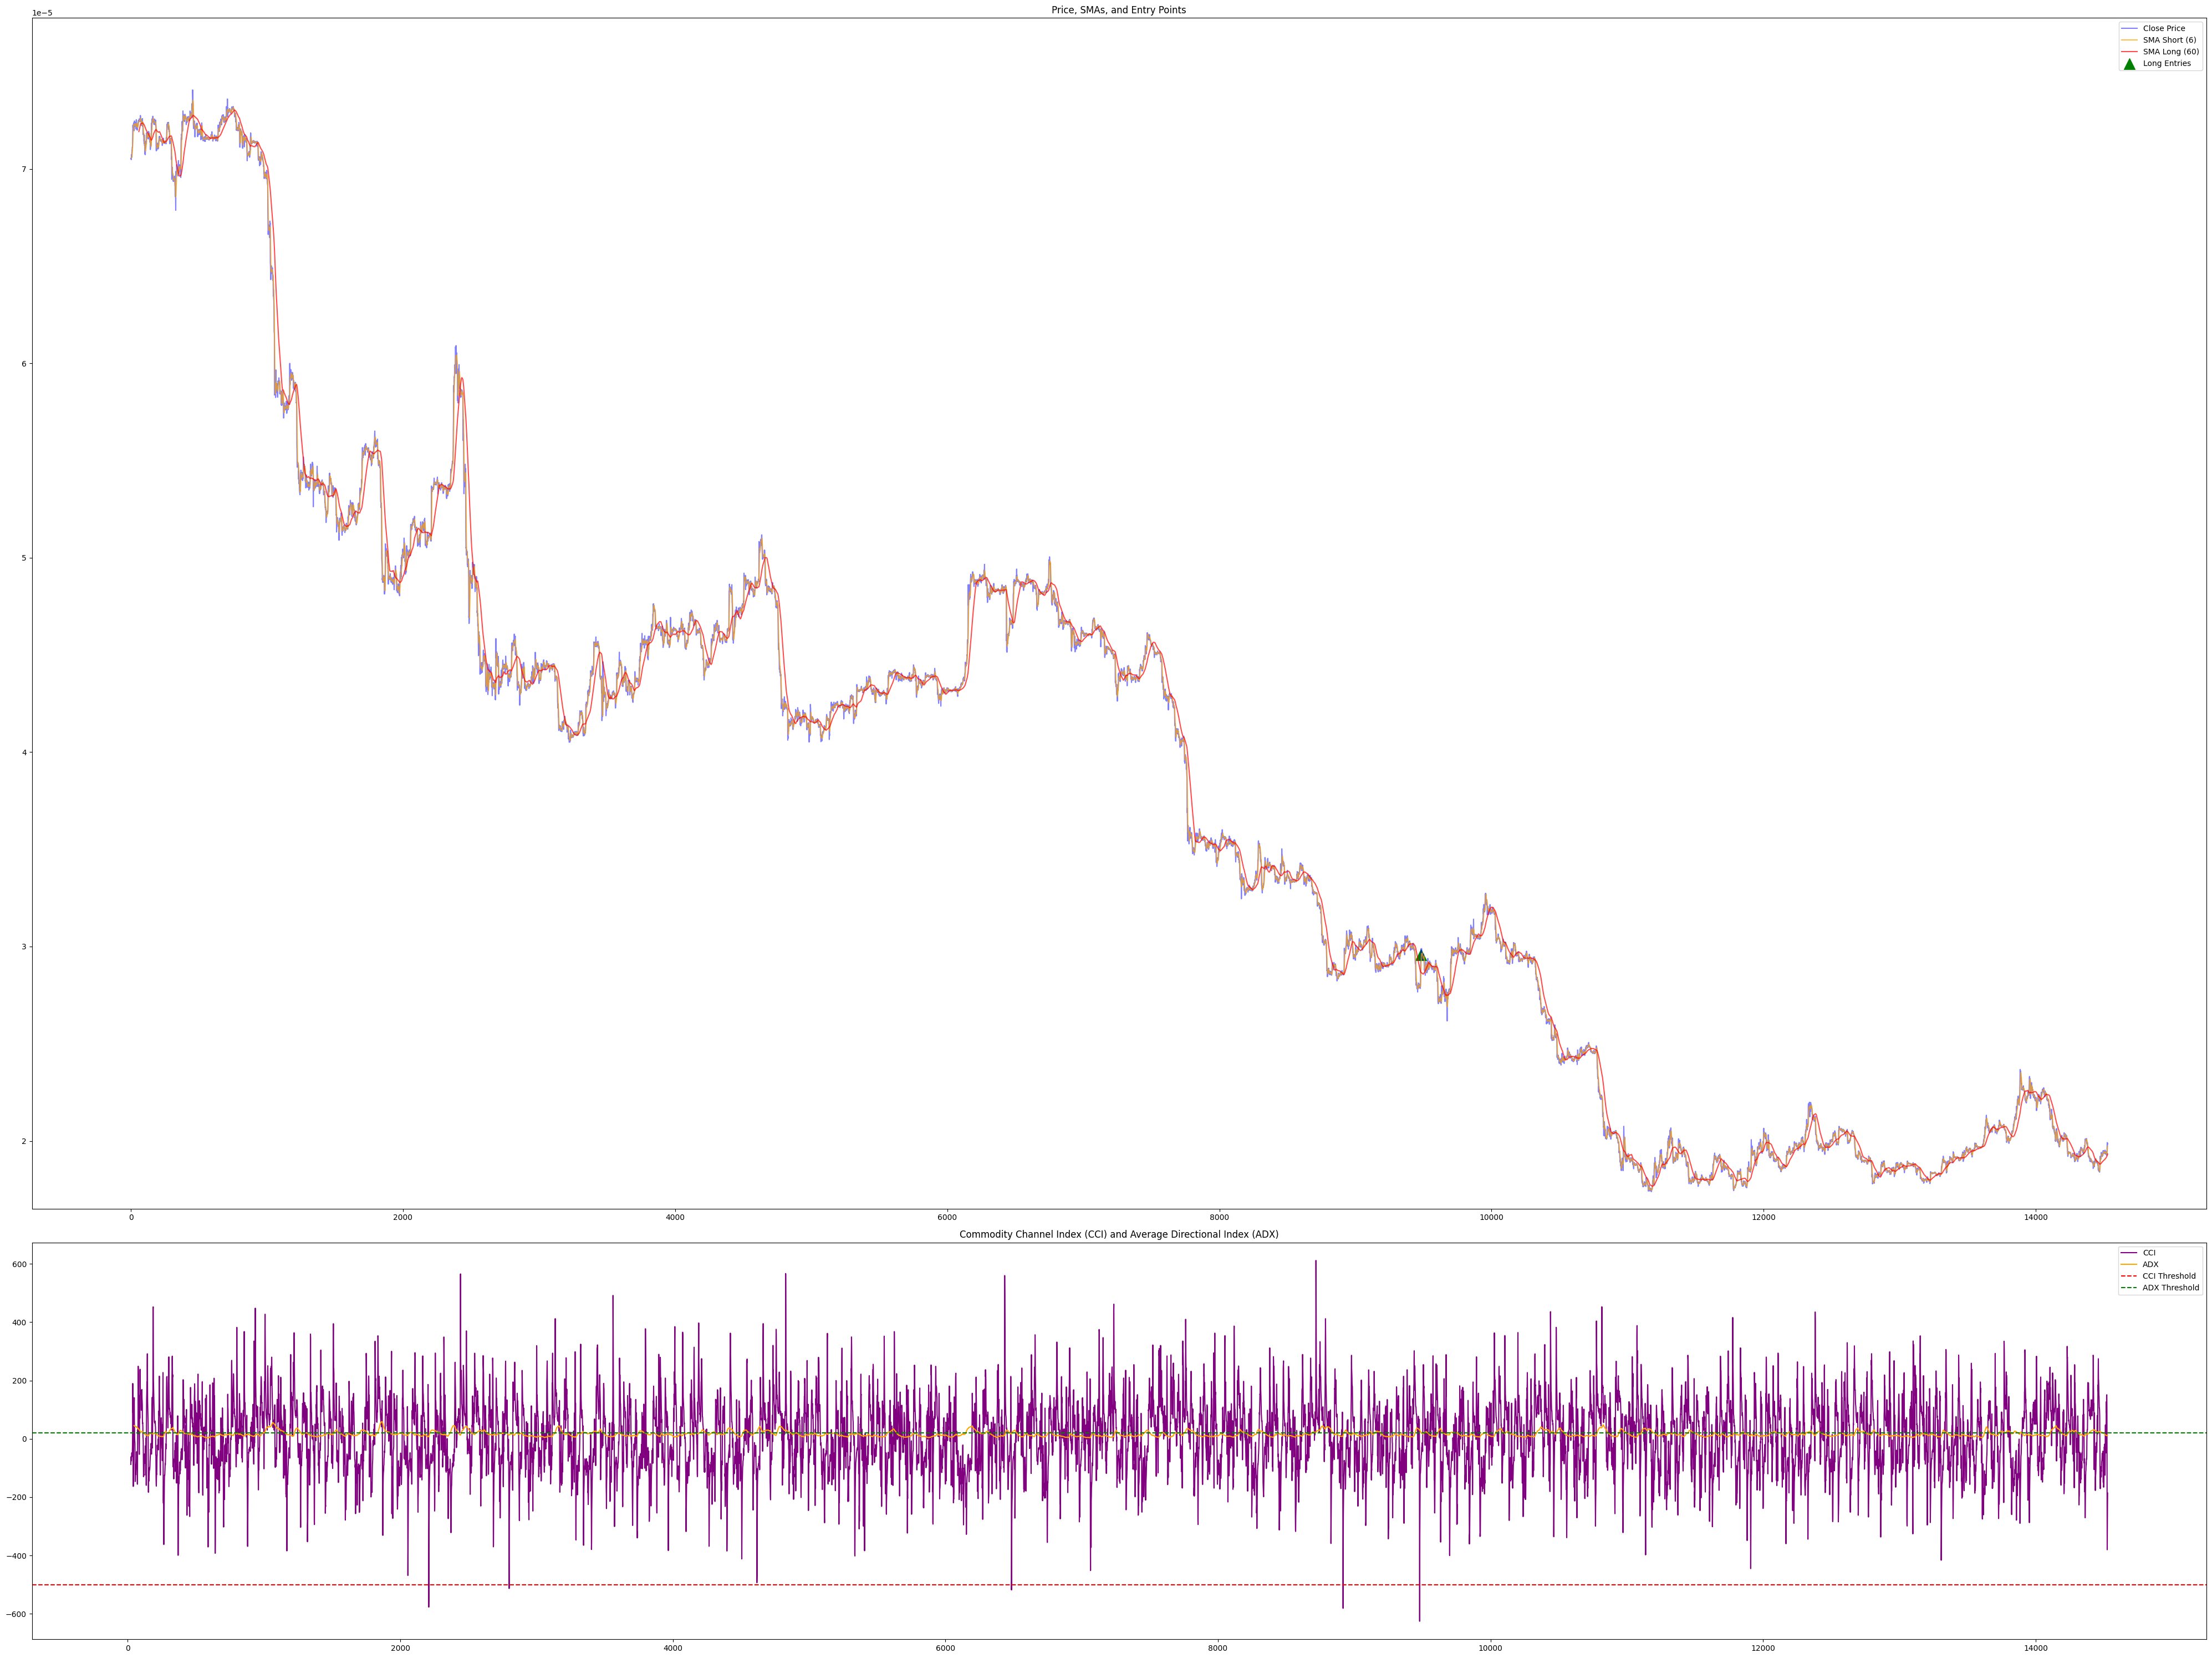

In [1524]:
# AdxSmaCciStrategy

data['close_minus_1'] = data['close'].shift(1)

# Calculate CCI
cci_length = 24
data['cci'] = pta.cci(data['high'], data['low'], data['close'], length=cci_length)

# Calculate SMA
sma_length_short = 6
sma_length_long = 60
data['sma_short'] = pta.sma(data['close'], length=sma_length_short)
data['sma_short_minus_1'] = data['sma_short'].shift(1)
data['sma_long'] = pta.sma(data['close'], length=sma_length_long)
data['sma_long_minus_1'] = data['sma_long'].shift(1)

# Calculate ADX
adx_length = 24
adx = pta.adx(data['high'], data['low'], data['close'], length=adx_length)
data['adx'] = adx['ADX_' + str(adx_length)]

# Define signals
cci_threshold = -500
adx_threshold = 20
data['cci_bullish'] = (data['cci'] < cci_threshold)
data['sma_buy'] = (data['sma_short'] > data['sma_long']) & (data['close'] > data['sma_short']) & (data['close_minus_1'] < data['sma_short_minus_1'])
data['strong_trend'] = data['adx'] > adx_threshold

# Combine signals
data['long_entry'] = (
    #data['sma_buy'] &
    data['cci_bullish'] &
    data['strong_trend']
)

# Update plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 30), gridspec_kw={'height_ratios': [3, 1]})

# Plot price, SMAs, and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.plot(data['sma_short'], label=f'SMA Short ({sma_length_short})', color='orange', alpha=0.7)
ax1.plot(data['sma_long'], label=f'SMA Long ({sma_length_long})', color='red', alpha=0.7)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=200)
ax1.set_title('Price, SMAs, and Entry Points')
ax1.legend()
ax1.set_ylim(data['close'].min() * 0.95, data['close'].max() * 1.05)

# Plot CCI and ADX
ax2.plot(data['cci'], label='CCI', color='purple')
ax2.plot(data['adx'], label='ADX', color='orange')
ax2.axhline(cci_threshold, color='red', linestyle='--', label='CCI Threshold')
ax2.axhline(adx_threshold, color='green', linestyle='--', label='ADX Threshold')
ax2.set_title('Commodity Channel Index (CCI) and Average Directional Index (ADX)')
ax2.legend()

plt.tight_layout()
plt.show()


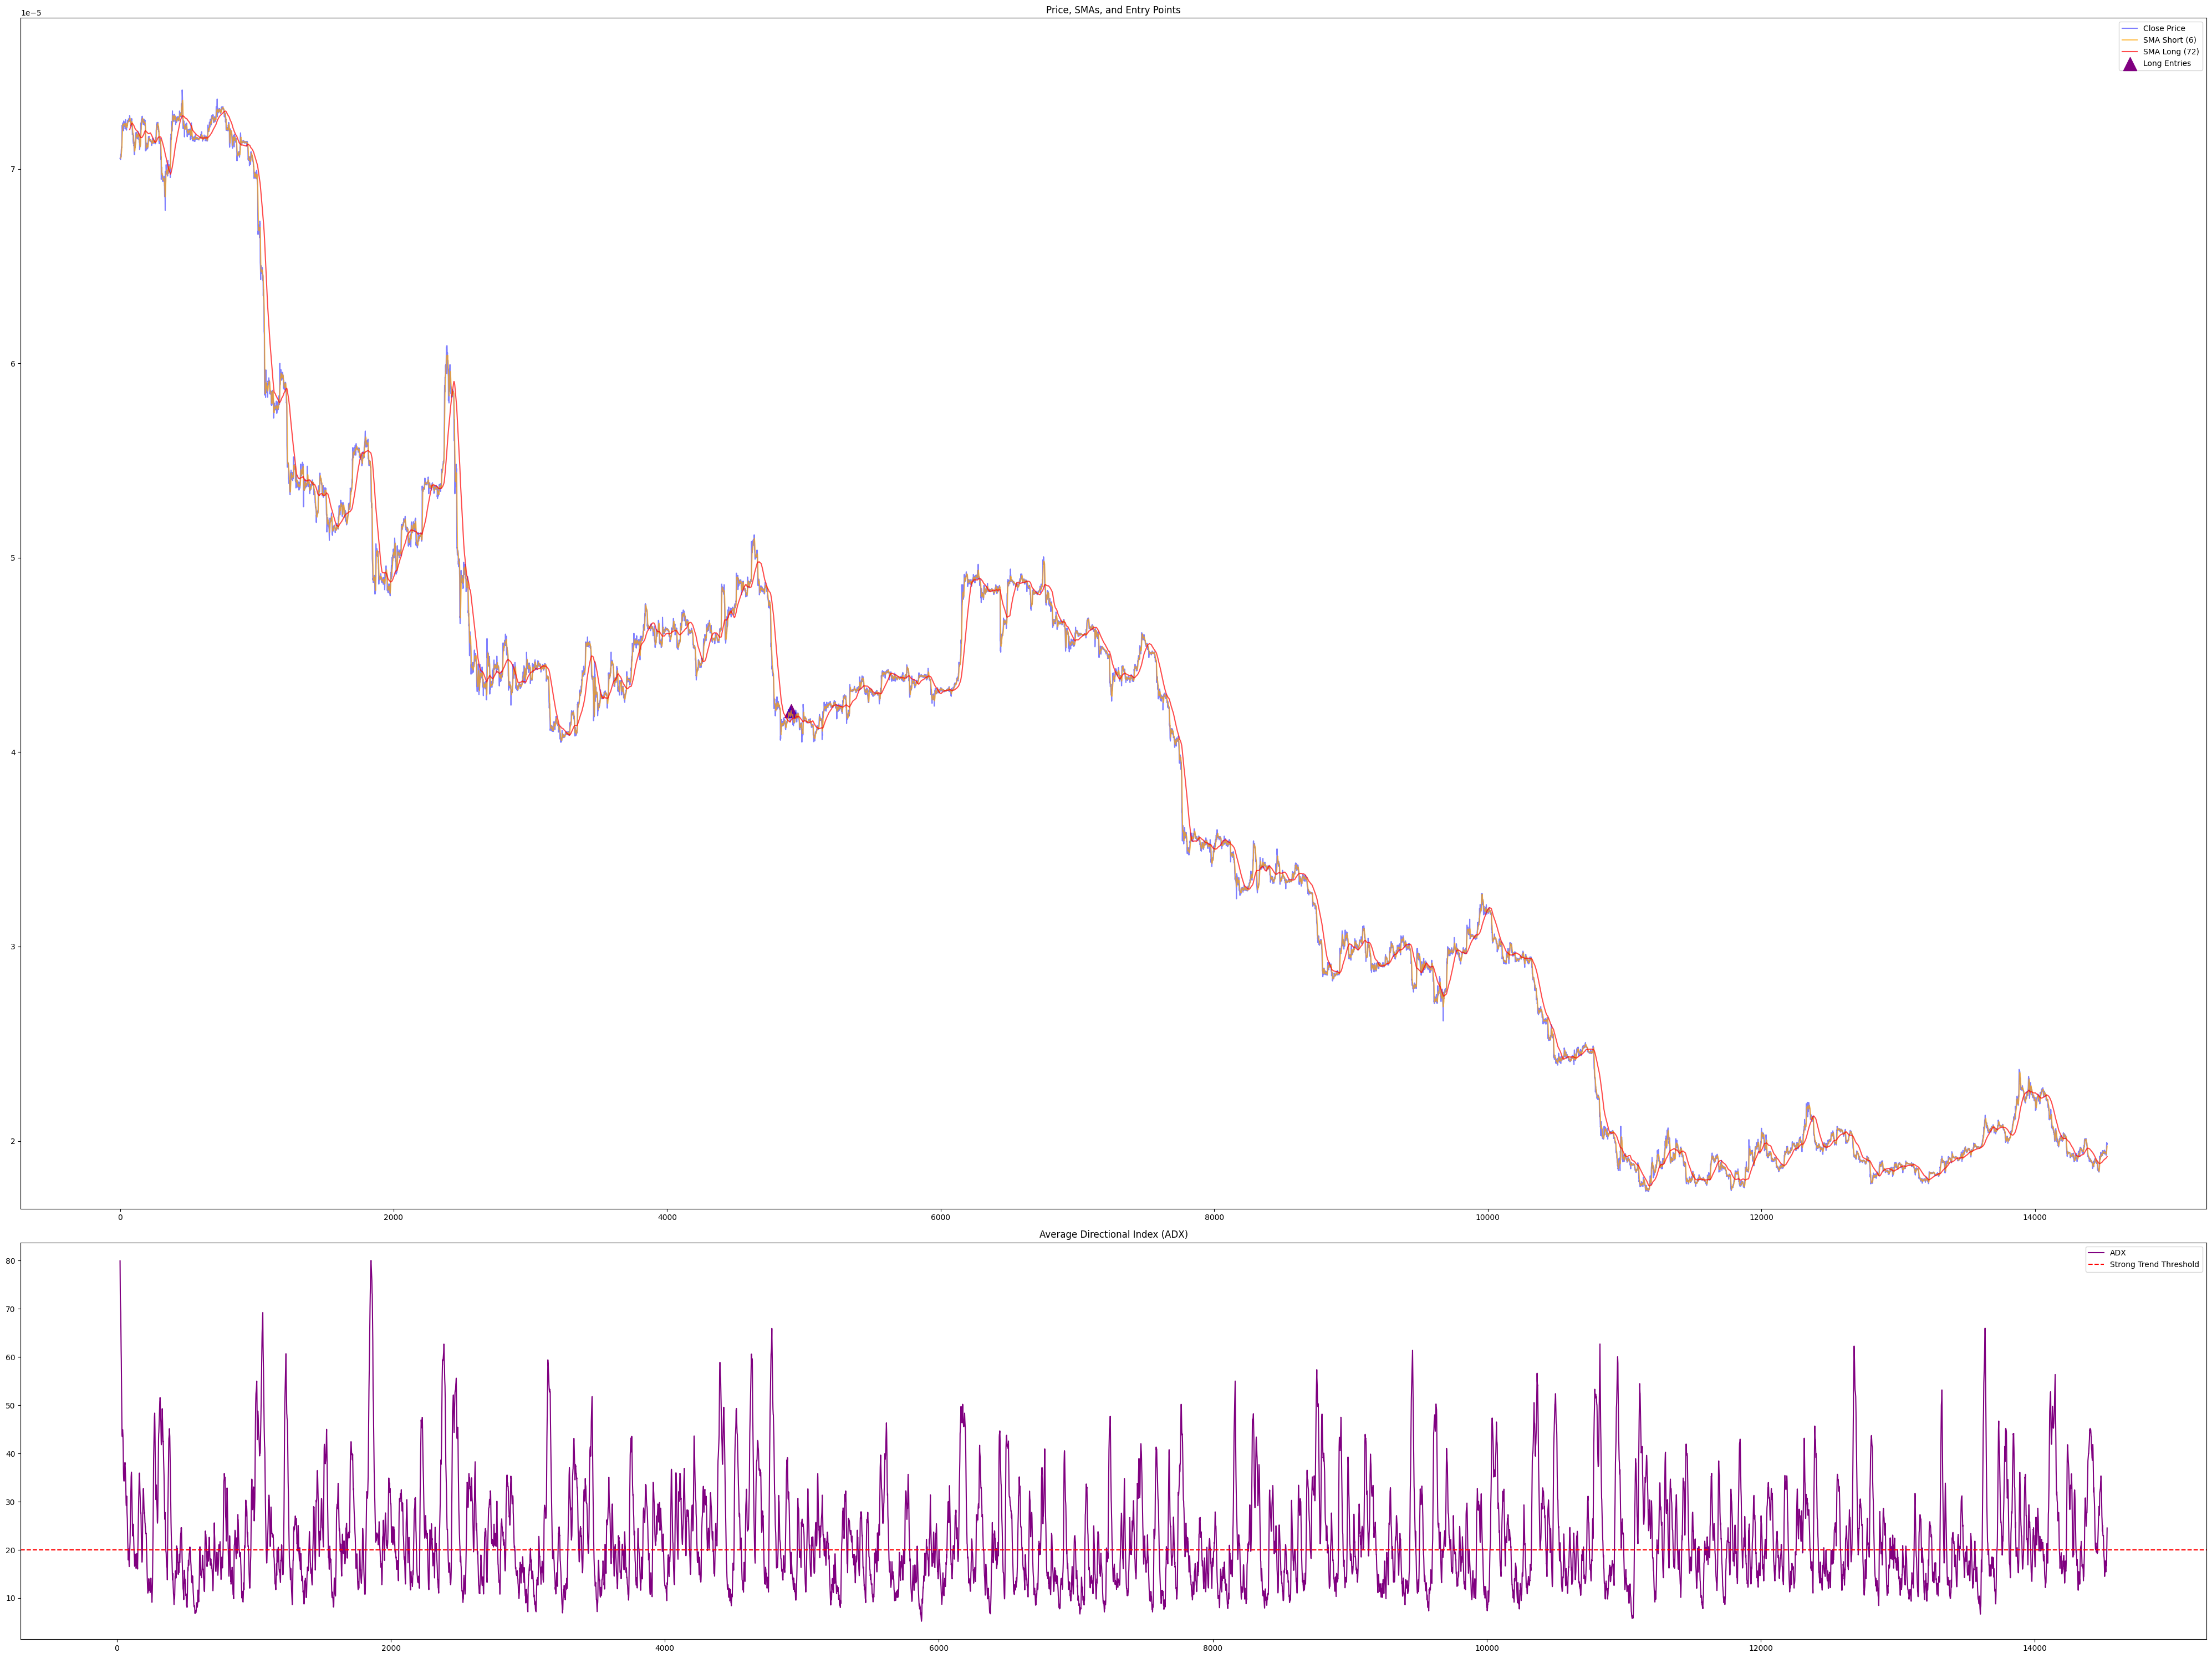

In [1527]:
# AdxEmaRsiStrategy

# Calculate SuperTrend, ADX, RSI, and EMA using pandas_ta
import pandas_ta as pta

# Calculate ADX
adx = pta.adx(data['high'], data['low'], data['close'], length=12)
data['adx_short'] = adx['ADX_12']

adx = pta.adx(data['high'], data['low'], data['close'], length=72)
data['adx_long'] = adx['ADX_72']

# Calculate RSI
data['rsi'] = pta.rsi(data['close'], length=24)

sma_length_short = 6
data['sma_short'] = pta.sma(data['close'], length=sma_length_short)

sma_length_long = 72
data['sma_long'] = pta.sma(data['close'], length=sma_length_long)

data['sma_long_diff'] = data['sma_long'].diff()

def is_local_minima(series, lookback: int = 3):
    # Ensure the lookback value is appropriate for the calculation
    if lookback < 2:
        raise ValueError("Lookback must be at least 2.")
    
    # Calculate the midpoint for splitting the lookback period
    midpoint = lookback // 2  # Integer division to ensure midpoint is an integer
    
    # Conditions for detecting a local minima
    # The first half should be decreasing (negative difference)
    conditions = [(series.shift(i) < 0) for i in range(lookback-1, midpoint-1, -1)]
    
    # The second half should be increasing (positive difference)
    conditions.extend([(series.shift(i) > 0) for i in range(midpoint-1, 0, -1)])
    
    # Check if all conditions are met
    return pd.concat(conditions, axis=1).all(axis=1)

# Apply the function to detect local minima
data['sma_long_minima'] = is_local_minima(data['sma_long_diff'], 12)

# Define signals
data['strong_trend'] = (data['adx_short'] > 30)# & (data['adx_long'] > 15)  # ADX threshold

rsi_lower_threshold = 30
rsi_upper_threshold = 60
data['rsi_not_overbought'] = (data['rsi'] < rsi_upper_threshold)
data['rsi_oversold'] = data['rsi'].rolling(window=12, min_periods=1).apply(lambda x: (x < rsi_lower_threshold).any(), raw=False) == True#

gradient_threshold = 0.0001
data['sma_buy'] = (data['sma_short'] > data['sma_long'])

#data['close_signal'] = (data['close'] > data['close_minus_1']) & (data['close_minus_1'] > data['close_minus_2'])

# Combine all conditions for long entry
data['long_entry'] = (
        #((data['rsi_oversold']) | (data['rsi_not_overbought'] & data['strong_trend'])) &
        #(data['close_signal'] & data['rsi_not_overbought'])# &
        (
            data['sma_buy'] & 
            data['strong_trend'] &
            data['rsi_not_overbought'] &
            data['sma_long_minima']
        )
        #(
            #data['sma_long_min']
            #& (data['sma_long_gradient'] > 0.0003)
            #& data['sma_buy']
            #& data['strong_recovery']
        #)
)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 30), gridspec_kw={'height_ratios': [3, 1]})

# Plot price, SMAs, and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.plot(data['sma_short'], label=f'SMA Short ({sma_length_short})', color='orange', alpha=0.7)
ax1.plot(data['sma_long'], label=f'SMA Long ({sma_length_long})', color='red', alpha=0.7)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='purple', marker='^', s=300)
ax1.set_title('Price, SMAs, and Entry Points')
ax1.legend()
ax1.set_ylim(data['close'].min() * 0.95, data['close'].max() * 1.05)

# Plot ADX
ax2.plot(data['adx'], label='ADX', color='purple')
ax2.axhline(20, color='red', linestyle='--', label='Strong Trend Threshold')
ax2.set_title('Average Directional Index (ADX)')
ax2.legend()

plt.tight_layout()
plt.show()


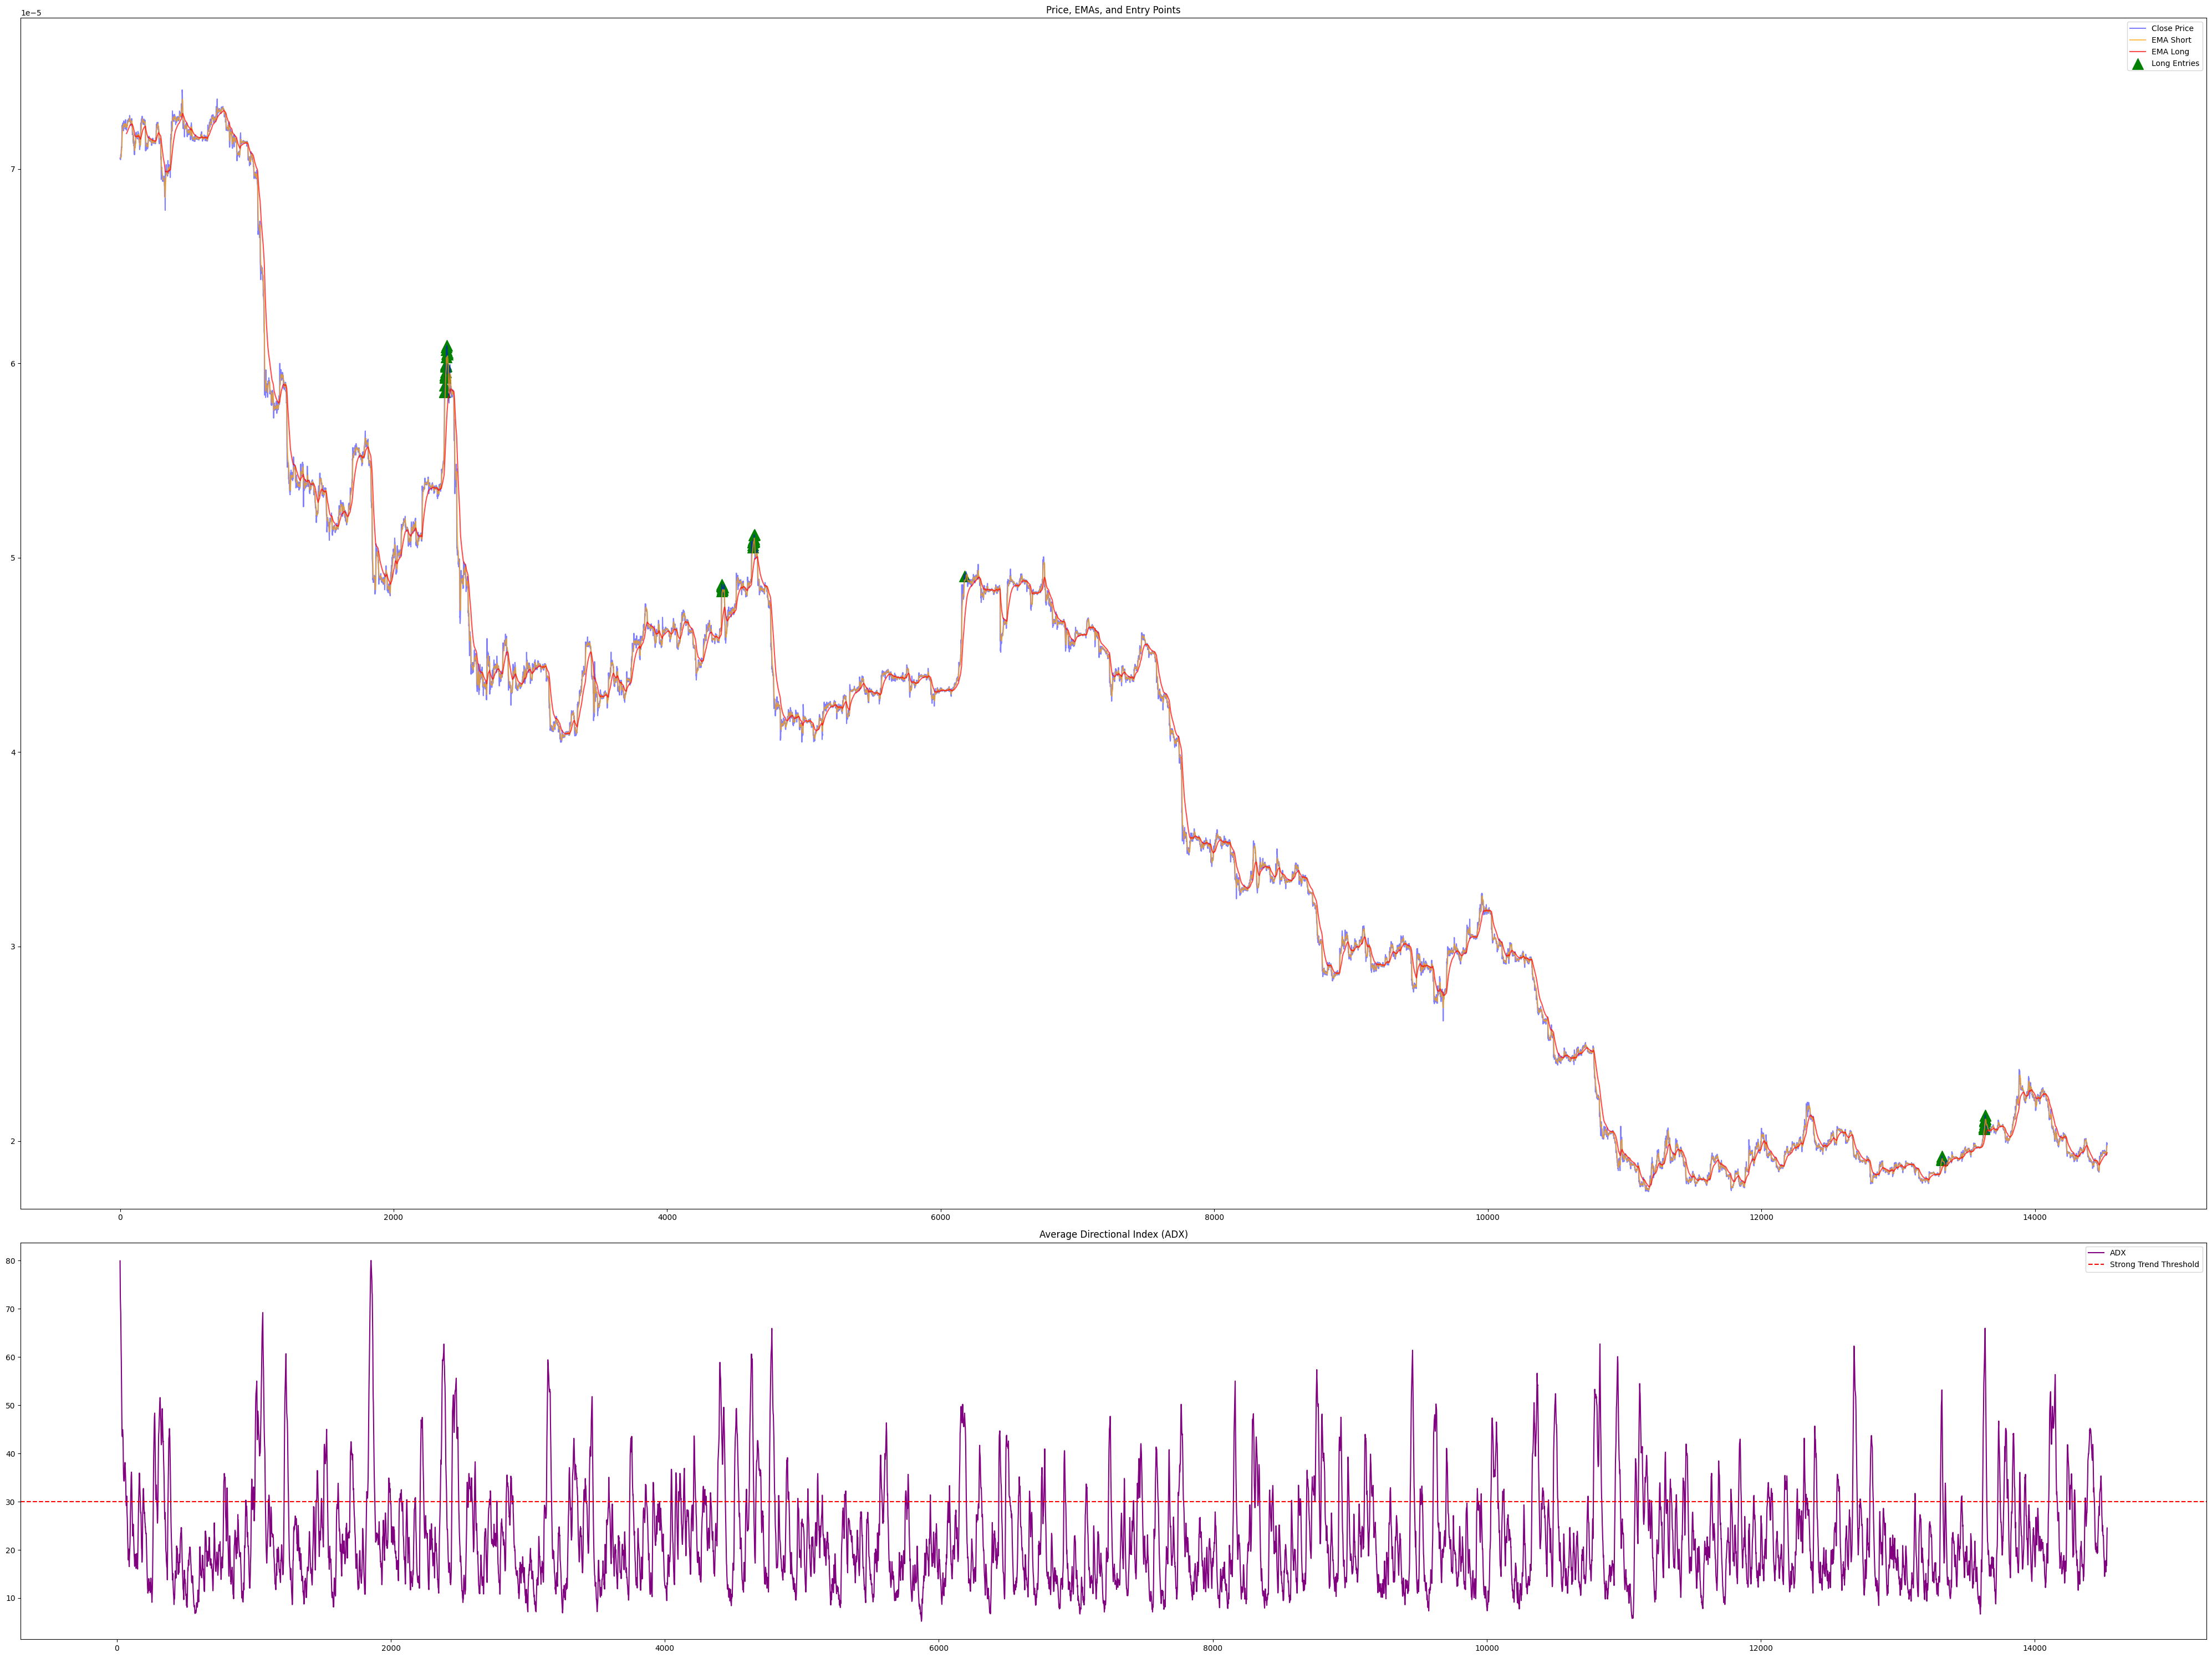

In [1526]:
#data = get_data_from_yfinance('ETH-GBP', start_date=pd.Timestamp('2022-12-01'), end_date=pd.Timestamp('2024-08-01'), invert_pair=True)

# AdxEmaStrategy

# Calculate ADX
adx = pta.adx(data['high'], data['low'], data['close'], length=12)
data['adx'] = adx['ADX_12']

# Calculate EMA
data['ema_short'] = pta.ema(data['close'], length=6)
data['ema_short_minus_1'] = data['ema_short'].shift(1)

data['ema_long'] = pta.ema(data['close'], length=48)
data['ema_long_minus_1'] = data['ema_long'].shift(1)
data['ema_long_gradient'] = (data['ema_long'] - data['ema_long_minus_1']) / data['ema_long_minus_1']

# Define signals
data['strong_trend'] = data['adx'] > 50
data['ema_buy'] = (data['ema_short'] > data['ema_long']) & (data['close'] > data['ema_short'])# & (data['ema_long_gradient'] > 0.0001)

# Combine all conditions for long entry
data['long_entry'] = (data['strong_trend'] & data['ema_buy'])

# Update plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 30), gridspec_kw={'height_ratios': [3, 1]})

# Plot price, EMAs, and entry points
ax1.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
ax1.plot(data['ema_short'], label='EMA Short', color='orange', alpha=0.7)
ax1.plot(data['ema_long'], label='EMA Long', color='red', alpha=0.7)
ax1.scatter(data.index[data['long_entry']], data['close'][data['long_entry']], label='Long Entries', color='green', marker='^', s=200)
ax1.set_title('Price, EMAs, and Entry Points')
ax1.legend()
ax1.set_ylim(data['close'].min() * 0.95, data['close'].max() * 1.05)

# Plot ADX
ax2.plot(data['adx'], label='ADX', color='purple')
ax2.axhline(30, color='red', linestyle='--', label='Strong Trend Threshold')
ax2.set_title('Average Directional Index (ADX)')
ax2.legend()

plt.tight_layout()
plt.show()
